In [1]:
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from flaml import tune
from flaml.tune.searcher import BlendSearch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score



In [2]:
X_train = pd.read_csv("/home/jovyan/work/juningpar/onsp/xgb_june/data/X_train.csv")
y_train  = pd.read_csv("/home/jovyan/work/juningpar/onsp/xgb_june/data/y_train.csv")
X_test = pd.read_csv("/home/jovyan/work/juningpar/onsp/xgb_june/data/X_test.csv")
y_test = pd.read_csv("/home/jovyan/work/juningpar/onsp/xgb_june/data/y_test.csv")

In [4]:
import numpy as np
import pandas as pd
import xgboost as xgb
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix
from flaml import BlendSearch


n_fold = 5
random_seed = 42
trial = 0
min_trials = 100
max_trials = 1500
step = 100
patience = 5
threshold = 0.8  # ปรับ threshold จากค่าเริ่มต้น 0.5 เป็น 0.3

results_list = []

def objective(config):
    global trial
    trial += 1
    
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': config['max_depth'],
        'min_child_weight': config['min_child_weight'],
        'subsample': config['subsample'],
        'learning_rate': config['learning_rate'],
        'colsample_bylevel': config['colsample_bylevel'],
        'colsample_bytree': config['colsample_bytree'],
        'gamma': config['gamma'],
        'reg_lambda': config['reg_lambda'],
        'reg_alpha': config['reg_alpha'],
        'n_estimators': config['n_estimators']
    }
    
    skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=random_seed)
    val_scores, acc_scores, f1_scores, precision_scores, f1_macro_scores = [], [], [], [], []
    kf_times = []
    prev_score = None
    stagnation_count = 0
    best_kf_score = 0
    best_n_estimators = 0
    
    for fold, (train_index, test_index) in tqdm(enumerate(skf.split(X_train, y_train)), total=n_fold, desc=f"Trial {trial}"):
        fold_start_time = time.time()
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        model = xgb.XGBClassifier(**params)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)
        preds_prob = model.predict_proba(X_val_fold)[:, 1]  # ค่าความน่าจะเป็นของ class 1
        preds = (preds_prob >= threshold).astype(int)  # ปรับ threshold เป็น 0.3
        
        val_score = recall_score(y_val_fold, preds, zero_division=0)
        acc_score = accuracy_score(y_val_fold, preds)
        precision = precision_score(y_val_fold, preds, zero_division=0)
        f1 = f1_score(y_val_fold, preds, zero_division=0)
        f1_macro = f1_score(y_val_fold, preds, average='macro', zero_division=0)
        
        val_scores.append(val_score)
        acc_scores.append(acc_score)
        precision_scores.append(precision)
        f1_scores.append(f1)
        f1_macro_scores.append(f1_macro)
        
        fold_time = time.time() - fold_start_time
        kf_times.append(fold_time)
        
        results_list.append([trial, fold + 1, val_score, acc_score, precision, f1, f1_macro, params['n_estimators'], fold_time])
        
        if val_score > best_kf_score:
            best_kf_score = val_score
            best_n_estimators = params['n_estimators']
        
        if prev_score is not None and abs(val_score - prev_score) < 1e-4:
            stagnation_count += 1
        else:
            stagnation_count = 0
        
        prev_score = val_score
        
        if stagnation_count >= patience:
            print(f"Stopping early due to stagnation at trial {trial}")
            break
    
    return {
        'recall': np.mean(val_scores),
        'accuracy': np.mean(acc_scores),
        'precision': np.mean(precision_scores),
        'f1': np.mean(f1_scores),
        'f1_macro': np.mean(f1_macro_scores),
        'best_n_estimators': best_n_estimators,
        'kf_time': np.sum(kf_times)
    }

start_time = time.time()

search_space = {
    'max_depth': tune.randint(3, 10),
    'min_child_weight': tune.loguniform(1e-8, 1e5),
    'subsample': tune.uniform(0.5, 1.0),
    'learning_rate': tune.loguniform(1e-5, 1.0),
    'colsample_bylevel': tune.uniform(0.5, 1.0),
    'colsample_bytree': tune.uniform(0.5, 1.0),
    'gamma': tune.loguniform(1e-8, 1e2),
    'reg_lambda': tune.loguniform(1e-8, 1e2),
    'reg_alpha': tune.loguniform(1e-8, 1e2),
    'n_estimators': tune.randint(100, 500)
}

blend_search = BlendSearch()
analysis = tune.run(
    objective,
    config=search_space,
    metric='recall',
    mode='max',
    search_alg=blend_search,
    num_samples=max_trials,
    verbose=1
)

time_taken = time.time() - start_time
best_config = analysis.best_config
best_score = analysis.best_result['recall']
best_accuracy = analysis.best_result['accuracy']
best_f1 = analysis.best_result['f1']

results = pd.DataFrame([[str(best_config), best_score, best_accuracy, best_f1, time_taken, trial]],
                       columns=['best_params', 'best_score', 'best_accuracy', 'best_f1', 'time_taken', 'trial'])
results.to_csv('./time/xgb_best_params2.csv', mode='a', header=not pd.io.common.file_exists('./time/xgb_best_params2.csv'), index=False)

# วาด Confusion Matrix
best_model = xgb.XGBClassifier(**best_config)
best_model.fit(X_train, y_train)
preds_prob = best_model.predict_proba(X_test)[:, 1]
preds = (preds_prob >= threshold).astype(int)
cm = confusion_matrix(y_test, preds)



/opt/conda/lib/python3.12/site-packages/flaml/tune/searcher/suggestion.py:886: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.IntDistribution` instead.
  return ot.distributions.IntUniformDistribution(
/opt/conda/lib/python3.12/site-packages/flaml/tune/searcher/suggestion.py:871: FutureWarning: LogUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.FloatDistribution` instead.
  return ot.distributions.LogUniformDistribution(domain.lower, domain.upper)
/opt/conda/lib/python3.12/site-packages/flaml/tune/searcher/suggestion.py:876: FutureWarning: UniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~opt

[flaml.tune.tune: 03-10 01:42:15] {891} INFO - trial 1 config: {'max_depth': 7, 'min_child_weight': 2.59692290753025, 'subsample': 0.681404614239038, 'learning_rate': 0.0006971034809046617, 'colsample_bylevel': 0.877743449018298, 'colsample_bytree': 0.6331962102154012, 'gamma': 0.3648436787087464, 'reg_lambda': 1.3680931439390769e-08, 'reg_alpha': 0.4711576651883603, 'n_estimators': 138}


Trial 1: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

[flaml.tune.tune: 03-10 01:42:17] {891} INFO - trial 2 config: {'max_depth': 8, 'min_child_weight': 1.861124137551614e-08, 'subsample': 0.8168241174631377, 'learning_rate': 0.05546505049361988, 'colsample_bylevel': 0.7492535061512953, 'colsample_bytree': 0.6123983227654238, 'gamma': 9.563759526973396e-07, 'reg_lambda': 0.40300192627116094, 'reg_alpha': 4.910303832962881e-07, 'n_estimators': 135}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:42:20] {891} INFO - trial 3 config: {'max_depth': 7, 'min_child_weight': 24780.696032168093, 'subsample': 0.5019741331639572, 'learning_rate': 0.0036388262327167738, 'colsample_bylevel': 0.9063104808260567, 'colsample_bytree': 0.8062630334146941, 'gamma': 0.16502630445045147, 'reg_lambda': 8.293936036104634e-06, 'reg_alpha': 15.05709620018309, 'n_estimators': 385}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:42:23] {891} INFO - trial 4 config: {'max_depth': 6, 'min_child_weight': 7.050349052657819e-07, 'subsample': 0.6866703800257346, 'learning_rate': 0.023478377182859902, 'colsample_bylevel': 0.720916587211498, 'colsample_bytree': 0.7170069966666468, 'gamma': 0.01505461954644427, 'reg_lambda': 0.0013532636785088263, 'reg_alpha': 0.03191330767951852, 'n_estimators': 340}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:42:31] {891} INFO - trial 5 config: {'max_depth': 8, 'min_child_weight': 0.06045232118709136, 'subsample': 0.9543244404043341, 'learning_rate': 0.0003946212291273759, 'colsample_bylevel': 0.5452296746354537, 'colsample_bytree': 0.6503500283181016, 'gamma': 1.3798873033847212e-07, 'reg_lambda': 1.935589524747966, 'reg_alpha': 2.944172107010871e-08, 'n_estimators': 350}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:42:35] {891} INFO - trial 6 config: {'max_depth': 6, 'min_child_weight': 447.43602049233664, 'subsample': 0.5994737698394061, 'learning_rate': 0.1924205768590666, 'colsample_bylevel': 0.6758263197160439, 'colsample_bytree': 0.8773238457649286, 'gamma': 9.112070449237827e-06, 'reg_lambda': 6.908198301652108, 'reg_alpha': 1.7993530249425475e-05, 'n_estimators': 166}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:42:37] {891} INFO - trial 7 config: {'max_depth': 5, 'min_child_weight': 1.640532616358043e-07, 'subsample': 0.9105528289184642, 'learning_rate': 5.698494037724682e-05, 'colsample_bylevel': 0.6920572243460998, 'colsample_bytree': 0.9721303561194006, 'gamma': 75.20639112807959, 'reg_lambda': 0.00036563307165740996, 'reg_alpha': 1.8248553218421582, 'n_estimators': 200}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:42:39] {891} INFO - trial 8 config: {'max_depth': 7, 'min_child_weight': 5455.2277207592915, 'subsample': 0.7672789744009075, 'learning_rate': 0.008933195015478923, 'colsample_bylevel': 0.5196408836126937, 'colsample_bytree': 0.6785908793172681, 'gamma': 6.253611557158484e-08, 'reg_lambda': 1.1339637812373682e-05, 'reg_alpha': 2.028584579475462e-05, 'n_estimators': 409}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:42:43] {891} INFO - trial 9 config: {'max_depth': 3, 'min_child_weight': 0.0038317601775931707, 'subsample': 0.6574634359213442, 'learning_rate': 0.015221439131647476, 'colsample_bylevel': 0.6731735750400165, 'colsample_bytree': 0.5215486781024972, 'gamma': 6.29726174643546, 'reg_lambda': 0.42894920912906814, 'reg_alpha': 6.0390194346543735, 'n_estimators': 267}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:42:47] {891} INFO - trial 10 config: {'max_depth': 7, 'min_child_weight': 0.04732233398325161, 'subsample': 0.7989183239814868, 'learning_rate': 0.00020468136551022507, 'colsample_bylevel': 0.6504356544703536, 'colsample_bytree': 0.5126998910250531, 'gamma': 1.0730639541716466e-05, 'reg_lambda': 2.6348673384545376e-06, 'reg_alpha': 0.003765146565681527, 'n_estimators': 326}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:42:56] {891} INFO - trial 11 config: {'max_depth': 6, 'min_child_weight': 6.40285536747325e-05, 'subsample': 0.5321255303474122, 'learning_rate': 0.7836023482451364, 'colsample_bylevel': 0.6698539218189319, 'colsample_bytree': 0.7475243154412272, 'gamma': 58.99392058481611, 'reg_lambda': 0.0002557044281735147, 'reg_alpha': 1.5230987257610725e-05, 'n_estimators': 307}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:42:59] {891} INFO - trial 12 config: {'max_depth': 7, 'min_child_weight': 1262.2307512110863, 'subsample': 0.534048636768975, 'learning_rate': 0.0021021032269263394, 'colsample_bylevel': 0.8909745593095741, 'colsample_bytree': 0.8593014051911252, 'gamma': 0.007248026967408783, 'reg_lambda': 2.349330583448069e-08, 'reg_alpha': 3.210435232290176e-05, 'n_estimators': 325}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:43:03] {891} INFO - trial 13 config: {'max_depth': 9, 'min_child_weight': 7.974334020601125, 'subsample': 0.8483004793767457, 'learning_rate': 1.4463029728321574e-05, 'colsample_bylevel': 0.9645485751333501, 'colsample_bytree': 0.851836637309503, 'gamma': 0.5586693407268218, 'reg_lambda': 2.2232656910574203e-08, 'reg_alpha': 42.531855812626695, 'n_estimators': 487}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:43:07] {891} INFO - trial 14 config: {'max_depth': 4, 'min_child_weight': 1.9195841933267506e-08, 'subsample': 0.664259361847189, 'learning_rate': 0.03991434678474159, 'colsample_bylevel': 0.822950362054527, 'colsample_bytree': 0.7604317148311178, 'gamma': 0.027315519262042207, 'reg_lambda': 0.019183748565723528, 'reg_alpha': 0.1843131828490317, 'n_estimators': 421}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:43:18] {891} INFO - trial 15 config: {'max_depth': 5, 'min_child_weight': 1.2586504712378812e-05, 'subsample': 0.680969768347136, 'learning_rate': 0.0024106997070698047, 'colsample_bylevel': 0.7914243676746763, 'colsample_bytree': 0.7507813621480733, 'gamma': 0.0002249740323433657, 'reg_lambda': 7.334948819972673e-06, 'reg_alpha': 0.05921428162943904, 'n_estimators': 410}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:43:29] {891} INFO - trial 16 config: {'max_depth': 9, 'min_child_weight': 77591.77653227528, 'subsample': 0.5086445980226204, 'learning_rate': 0.046800057889126404, 'colsample_bylevel': 0.9998096128743943, 'colsample_bytree': 0.6221376580837649, 'gamma': 0.20352115958558753, 'reg_lambda': 0.012399541609584792, 'reg_alpha': 99.96683243242387, 'n_estimators': 248}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:43:32] {891} INFO - trial 17 config: {'max_depth': 5, 'min_child_weight': 7.661591812987521, 'subsample': 0.5891061526984538, 'learning_rate': 0.0006329957315068293, 'colsample_bylevel': 0.8799498323786519, 'colsample_bytree': 0.8072950635887467, 'gamma': 0.0011951468344815913, 'reg_lambda': 5.056455998506666e-07, 'reg_alpha': 0.006540603403391225, 'n_estimators': 374}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:43:40] {891} INFO - trial 18 config: {'max_depth': 8, 'min_child_weight': 7.18469502628542e-05, 'subsample': 0.7134331046965464, 'learning_rate': 0.008005915601513492, 'colsample_bylevel': 0.7408748431323344, 'colsample_bytree': 0.956024177358658, 'gamma': 0.2795674724424246, 'reg_lambda': 0.00017170780451962735, 'reg_alpha': 0.49647680366218744, 'n_estimators': 494}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:43:51] {891} INFO - trial 19 config: {'max_depth': 8, 'min_child_weight': 1.0602550468252509e-06, 'subsample': 0.6129782551485943, 'learning_rate': 0.16250462805548446, 'colsample_bylevel': 0.596466912472741, 'colsample_bytree': 0.681748836435409, 'gamma': 0.0003466010043807488, 'reg_lambda': 0.012970510023759624, 'reg_alpha': 0.02890760184542342, 'n_estimators': 260}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:43:56] {891} INFO - trial 20 config: {'max_depth': 6, 'min_child_weight': 4.613115037097065, 'subsample': 0.8458772032923556, 'learning_rate': 0.0014270401586975996, 'colsample_bylevel': 0.9000842706372457, 'colsample_bytree': 0.5788518944089992, 'gamma': 2.3438902777139012, 'reg_lambda': 3.7919619892064736e-05, 'reg_alpha': 6.7803717426568655, 'n_estimators': 440}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:44:00] {891} INFO - trial 21 config: {'max_depth': 4, 'min_child_weight': 0.0005944831528804024, 'subsample': 0.7355010104586703, 'learning_rate': 0.06915400680978713, 'colsample_bylevel': 0.7935032986723124, 'colsample_bytree': 0.9143110152824694, 'gamma': 0.015377304935189805, 'reg_lambda': 3.3506814118562206e-07, 'reg_alpha': 0.0006879762047971899, 'n_estimators': 364}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:44:06] {891} INFO - trial 22 config: {'max_depth': 7, 'min_child_weight': 0.38365608256228756, 'subsample': 0.5650623078869008, 'learning_rate': 0.8334134095355901, 'colsample_bylevel': 0.7302029474891368, 'colsample_bytree': 0.7187540460424069, 'gamma': 3.927387109664253e-05, 'reg_lambda': 0.15106376863864274, 'reg_alpha': 0.00039954626552390964, 'n_estimators': 206}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:44:09] {891} INFO - trial 23 config: {'max_depth': 6, 'min_child_weight': 116.31505688797809, 'subsample': 0.6342753778641423, 'learning_rate': 0.005865087869887749, 'colsample_bylevel': 0.8395638577314086, 'colsample_bytree': 0.7967052339393408, 'gamma': 0.042086087443418435, 'reg_lambda': 0.0025816510892527557, 'reg_alpha': 2.1590153805447692e-08, 'n_estimators': 107}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:44:11] {891} INFO - trial 24 config: {'max_depth': 8, 'min_child_weight': 0.017253316405121125, 'subsample': 0.9556293754398935, 'learning_rate': 0.0003559836538096338, 'colsample_bylevel': 0.5293282275305876, 'colsample_bytree': 0.6260314537648717, 'gamma': 2.7282920048758444e-08, 'reg_lambda': 3.95810451345498, 'reg_alpha': 1.2050237728901959e-08, 'n_estimators': 359}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:44:14] {891} INFO - trial 25 config: {'max_depth': 8, 'min_child_weight': 1.7368738258071168e-06, 'subsample': 0.9893029795429195, 'learning_rate': 8.89004384885045e-05, 'colsample_bylevel': 0.5962270134108456, 'colsample_bytree': 0.6733294564058535, 'gamma': 0.005287341686527139, 'reg_lambda': 88.11603061919462, 'reg_alpha': 5.669524638550695e-07, 'n_estimators': 375}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:44:18] {891} INFO - trial 26 config: {'max_depth': 9, 'min_child_weight': 0.3087252576404682, 'subsample': 0.8600447442050441, 'learning_rate': 0.0008289774514711014, 'colsample_bylevel': 0.5795400053705766, 'colsample_bytree': 0.8067300692727676, 'gamma': 3.3532735194258877e-06, 'reg_lambda': 0.26386898385228635, 'reg_alpha': 1.0435275915082336e-06, 'n_estimators': 289}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:44:23] {891} INFO - trial 27 config: {'max_depth': 7, 'min_child_weight': 0.0009701312254554212, 'subsample': 0.7984050046779136, 'learning_rate': 0.01987454607459427, 'colsample_bylevel': 0.9542416853980975, 'colsample_bytree': 0.6064684574844575, 'gamma': 2.3737134470627975e-07, 'reg_lambda': 97.89853785962553, 'reg_alpha': 0.00019812788034636548, 'n_estimators': 339}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:44:29] {891} INFO - trial 28 config: {'max_depth': 8, 'min_child_weight': 92171.33361571189, 'subsample': 0.8874970583416714, 'learning_rate': 0.004193706148171656, 'colsample_bylevel': 0.7715850711201553, 'colsample_bytree': 0.7098974207435962, 'gamma': 0.0015101957322147196, 'reg_lambda': 4.3534490481818796e-05, 'reg_alpha': 1.5809069267104838e-07, 'n_estimators': 449}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:44:34] {891} INFO - trial 29 config: {'max_depth': 7, 'min_child_weight': 3.4994249623408525e-08, 'subsample': 0.7866158268799546, 'learning_rate': 0.00022381347178223332, 'colsample_bylevel': 0.5643682238690177, 'colsample_bytree': 0.5642360107608921, 'gamma': 6.805709820494052e-07, 'reg_lambda': 0.0031066417401811844, 'reg_alpha': 0.009737234117297256, 'n_estimators': 387}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:44:52] {891} INFO - trial 30 config: {'max_depth': 6, 'min_child_weight': 74.7641843197662, 'subsample': 0.9325678516387719, 'learning_rate': 3.83515376171927e-05, 'colsample_bylevel': 0.7129368674898708, 'colsample_bytree': 0.6507194444465513, 'gamma': 0.00011367752563145877, 'reg_lambda': 6.96397876820634e-07, 'reg_alpha': 0.6668964401732799, 'n_estimators': 292}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:44:57] {891} INFO - trial 31 config: {'max_depth': 8, 'min_child_weight': 0.5006043507946164, 'subsample': 0.7019498633716877, 'learning_rate': 0.0008850777599333194, 'colsample_bylevel': 0.6314635577529539, 'colsample_bytree': 0.7157176789117081, 'gamma': 1.0350427917295269e-08, 'reg_lambda': 1.4804994454628588, 'reg_alpha': 15.59510604303745, 'n_estimators': 466}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:45:07] {891} INFO - trial 32 config: {'max_depth': 5, 'min_child_weight': 5277.681231473433, 'subsample': 0.9892131439569511, 'learning_rate': 0.1217845534103982, 'colsample_bylevel': 0.9270428552200287, 'colsample_bytree': 0.8893608998733656, 'gamma': 6.202605576901993, 'reg_lambda': 13.06567935725968, 'reg_alpha': 3.932886661861778e-06, 'n_estimators': 346}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:45:18] {891} INFO - trial 33 config: {'max_depth': 6, 'min_child_weight': 1.0787821140337853e-05, 'subsample': 0.5564353984881795, 'learning_rate': 0.01620070343472134, 'colsample_bylevel': 0.8544759458916862, 'colsample_bytree': 0.7820057830340459, 'gamma': 0.09287240432583044, 'reg_lambda': 0.04208612112867031, 'reg_alpha': 8.999254510598965e-05, 'n_estimators': 398}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:45:50] {891} INFO - trial 34 config: {'max_depth': 6, 'min_child_weight': 242.71044804708978, 'subsample': 0.6057164571531638, 'learning_rate': 0.2590246607625466, 'colsample_bylevel': 0.6946544111048336, 'colsample_bytree': 0.8547527892663102, 'gamma': 1.0979790868906367e-05, 'reg_lambda': 14.630536910278288, 'reg_alpha': 8.790267687718952e-08, 'n_estimators': 139}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:45:53] {891} INFO - trial 35 config: {'max_depth': 7, 'min_child_weight': 11140.44443847694, 'subsample': 0.631680366288798, 'learning_rate': 0.03175564728022957, 'colsample_bylevel': 0.6210943060988008, 'colsample_bytree': 0.9639703607669018, 'gamma': 1.0606999819581814e-06, 'reg_lambda': 5.798598330352535, 'reg_alpha': 0.0021269766436088355, 'n_estimators': 208}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:45:57] {891} INFO - trial 36 config: {'max_depth': 4, 'min_child_weight': 795.3189642298556, 'subsample': 0.503627755755135, 'learning_rate': 0.3854822814087761, 'colsample_bylevel': 0.5075363458642234, 'colsample_bytree': 0.9973452185068449, 'gamma': 1.208409283816945e-07, 'reg_lambda': 0.0006769189095165349, 'reg_alpha': 1.3159072141875046, 'n_estimators': 172}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:46:02] {891} INFO - trial 37 config: {'max_depth': 7, 'min_child_weight': 13833.006371096304, 'subsample': 0.7605436612189137, 'learning_rate': 0.09151763978035418, 'colsample_bylevel': 0.5501018444271975, 'colsample_bytree': 0.8298826186801463, 'gamma': 3.0690976958723846e-05, 'reg_lambda': 0.9436338837076826, 'reg_alpha': 4.827705632650068e-06, 'n_estimators': 225}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:46:07] {891} INFO - trial 38 config: {'max_depth': 6, 'min_child_weight': 40.4125422795823, 'subsample': 0.5770588116381327, 'learning_rate': 9.976334561261053e-05, 'colsample_bylevel': 0.6754109870977654, 'colsample_bytree': 0.6875561989923137, 'gamma': 2.7117367446082354e-06, 'reg_lambda': 30.574415281398213, 'reg_alpha': 0.0883021499126472, 'n_estimators': 325}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:46:12] {891} INFO - trial 39 config: {'max_depth': 7, 'min_child_weight': 0.04902977425347816, 'subsample': 0.5384996125762939, 'learning_rate': 0.012347781485198705, 'colsample_bylevel': 0.7647853349796873, 'colsample_bytree': 0.9293609232603138, 'gamma': 83.86771853384961, 'reg_lambda': 0.09181276733561172, 'reg_alpha': 8.488899152232319e-08, 'n_estimators': 175}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:46:15] {891} INFO - trial 40 config: {'max_depth': 5, 'min_child_weight': 1919.7392676856539, 'subsample': 0.6443322780295574, 'learning_rate': 0.004100928240540146, 'colsample_bylevel': 0.6402513631357605, 'colsample_bytree': 0.8900476389568999, 'gamma': 0.004357241471055446, 'reg_lambda': 1.195651890401183e-07, 'reg_alpha': 5.3964932145917366e-05, 'n_estimators': 306}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:46:23] {891} INFO - trial 41 config: {'max_depth': 6, 'min_child_weight': 1.821130285601504e-07, 'subsample': 0.7332534828791246, 'learning_rate': 0.3688429367630832, 'colsample_bylevel': 0.7027128982388976, 'colsample_bytree': 0.7612367068918363, 'gamma': 1.031368637916628, 'reg_lambda': 1.0161529529915316, 'reg_alpha': 1.162089377407004e-05, 'n_estimators': 271}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:46:30] {891} INFO - trial 42 config: {'max_depth': 3, 'min_child_weight': 0.0063112163284027465, 'subsample': 0.6847236547119376, 'learning_rate': 0.0018971614786583474, 'colsample_bylevel': 0.6619678557921296, 'colsample_bytree': 0.8302605630265916, 'gamma': 17.79716267742134, 'reg_lambda': 8.165508938990776e-05, 'reg_alpha': 2.720601276380136, 'n_estimators': 420}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:46:37] {891} INFO - trial 43 config: {'max_depth': 9, 'min_child_weight': 2.727162192213662, 'subsample': 0.6615809644914834, 'learning_rate': 0.02671032784297077, 'colsample_bylevel': 0.8124269587470998, 'colsample_bytree': 0.7293032033229045, 'gamma': 3.711635289704096e-07, 'reg_lambda': 2.4918357229558053e-06, 'reg_alpha': 7.264752819582115e-07, 'n_estimators': 325}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:46:47] {891} INFO - trial 44 config: {'max_depth': 5, 'min_child_weight': 7.732337731228199e-08, 'subsample': 0.9230018158979811, 'learning_rate': 1.4672952002422784e-05, 'colsample_bylevel': 0.6822334483240412, 'colsample_bytree': 0.9923499760060266, 'gamma': 24.12003420114777, 'reg_lambda': 6.409402324977769e-06, 'reg_alpha': 19.581535187872763, 'n_estimators': 168}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:46:50] {891} INFO - trial 45 config: {'max_depth': 5, 'min_child_weight': 1.0655178659664287e-08, 'subsample': 0.8991160873572026, 'learning_rate': 5.004907351656927e-05, 'colsample_bylevel': 0.7446215308016803, 'colsample_bytree': 0.8854776841523316, 'gamma': 0.11152300711747755, 'reg_lambda': 0.0005288037010198435, 'reg_alpha': 0.2137186249423948, 'n_estimators': 113}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:46:52] {891} INFO - trial 46 config: {'max_depth': 5, 'min_child_weight': 4.117359983424269e-07, 'subsample': 0.8241944086909204, 'learning_rate': 0.0003617743501513833, 'colsample_bylevel': 0.7181158105839179, 'colsample_bytree': 0.9470598967362069, 'gamma': 1.6680749610584449, 'reg_lambda': 0.002429948366521522, 'reg_alpha': 0.022371864912721137, 'n_estimators': 241}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:46:56] {891} INFO - trial 47 config: {'max_depth': 6, 'min_child_weight': 6.21596984915452e-05, 'subsample': 0.9553310844058922, 'learning_rate': 1.7552131929023808e-05, 'colsample_bylevel': 0.6157577473216129, 'colsample_bytree': 0.8330852374559903, 'gamma': 0.00046284032710531235, 'reg_lambda': 1.7483105449673656e-05, 'reg_alpha': 95.27998656247286, 'n_estimators': 156}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:46:58] {891} INFO - trial 48 config: {'max_depth': 4, 'min_child_weight': 3.846044386392307e-06, 'subsample': 0.604772934999811, 'learning_rate': 0.00012374896756789687, 'colsample_bylevel': 0.6557125175461775, 'colsample_bytree': 0.6547977509637315, 'gamma': 0.001947307639017869, 'reg_lambda': 0.00034660745698562916, 'reg_alpha': 6.0740721186530475, 'n_estimators': 347}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:47:03] {891} INFO - trial 49 config: {'max_depth': 7, 'min_child_weight': 0.00018251628007260264, 'subsample': 0.5235898733750765, 'learning_rate': 2.916121266857401e-05, 'colsample_bylevel': 0.7701612876781312, 'colsample_bytree': 0.7776441826714442, 'gamma': 0.01717569799310477, 'reg_lambda': 0.00014084601328990444, 'reg_alpha': 0.0013603279697922926, 'n_estimators': 139}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:47:08] {891} INFO - trial 50 config: {'max_depth': 6, 'min_child_weight': 35130.5898819904, 'subsample': 0.7099590170027059, 'learning_rate': 0.056903470945450514, 'colsample_bylevel': 0.7991929690764392, 'colsample_bytree': 0.7414439410183182, 'gamma': 0.5896417011686018, 'reg_lambda': 0.0071667234360876, 'reg_alpha': 0.39752993294628103, 'n_estimators': 387}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:47:12] {891} INFO - trial 51 config: {'max_depth': 5, 'min_child_weight': 507.6246380159724, 'subsample': 0.9596285937880698, 'learning_rate': 0.008442934103060046, 'colsample_bylevel': 0.9921737836154437, 'colsample_bytree': 0.9735929831150653, 'gamma': 6.14788603610428e-08, 'reg_lambda': 1.1772751648721685e-08, 'reg_alpha': 15.97270125981144, 'n_estimators': 190}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:47:16] {891} INFO - trial 52 config: {'max_depth': 8, 'min_child_weight': 30.27531707696596, 'subsample': 0.5921942930479944, 'learning_rate': 0.0005273119936560166, 'colsample_bylevel': 0.8624984634770323, 'colsample_bytree': 0.9244008019656941, 'gamma': 7.127168926016247e-05, 'reg_lambda': 1.7531967779888166e-06, 'reg_alpha': 2.3090829989166273, 'n_estimators': 281}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:47:20] {891} INFO - trial 53 config: {'max_depth': 7, 'min_child_weight': 3899.151537324477, 'subsample': 0.8786469085229028, 'learning_rate': 0.0013732095726683795, 'colsample_bylevel': 0.5389841893041581, 'colsample_bytree': 0.5025735638397476, 'gamma': 0.050129330115126915, 'reg_lambda': 5.2871130251838975e-08, 'reg_alpha': 0.008380549773519192, 'n_estimators': 408}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:47:29] {891} INFO - trial 54 config: {'max_depth': 6, 'min_child_weight': 25263.829502918546, 'subsample': 0.7764379934084038, 'learning_rate': 0.007124759897435391, 'colsample_bylevel': 0.5014011499177212, 'colsample_bytree': 0.6964731189077374, 'gamma': 3.246843054432048e-08, 'reg_lambda': 9.51848738486812e-06, 'reg_alpha': 1.9655604365600124e-05, 'n_estimators': 438}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:47:35] {891} INFO - trial 55 config: {'max_depth': 7, 'min_child_weight': 4.305510211808808e-07, 'subsample': 0.8278080761777977, 'learning_rate': 0.0026004392438444685, 'colsample_bylevel': 0.5241638869730397, 'colsample_bytree': 0.6391483620169456, 'gamma': 4.759062483873642e-06, 'reg_lambda': 2.4390843986064943e-05, 'reg_alpha': 0.00020858820299603413, 'n_estimators': 367}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:47:48] {891} INFO - trial 56 config: {'max_depth': 8, 'min_child_weight': 1802.5085971783114, 'subsample': 0.6758613193655809, 'learning_rate': 0.003766956214208327, 'colsample_bylevel': 0.5874938514962668, 'colsample_bytree': 0.5410043403015562, 'gamma': 6.49904569601273e-08, 'reg_lambda': 1.1922490140762272e-06, 'reg_alpha': 2.1519644119672672e-06, 'n_estimators': 312}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:47:53] {891} INFO - trial 57 config: {'max_depth': 7, 'min_child_weight': 0.12001372625331258, 'subsample': 0.9097924945249952, 'learning_rate': 0.010097786868123449, 'colsample_bylevel': 0.5601744278921664, 'colsample_bytree': 0.6083445802283934, 'gamma': 1.086340586039047e-06, 'reg_lambda': 4.759917437395289e-06, 'reg_alpha': 2.0692544786755114e-07, 'n_estimators': 353}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:48:03] {891} INFO - trial 58 config: {'max_depth': 8, 'min_child_weight': 2.331150671425421, 'subsample': 0.6198643943574198, 'learning_rate': 0.0012688248940417614, 'colsample_bylevel': 0.7374261539449727, 'colsample_bytree': 0.6751683273026338, 'gamma': 1.1988638222977164e-08, 'reg_lambda': 0.0013386309153083174, 'reg_alpha': 0.05370528395857993, 'n_estimators': 389}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:48:12] {891} INFO - trial 59 config: {'max_depth': 9, 'min_child_weight': 13.568045384432923, 'subsample': 0.5499283688360871, 'learning_rate': 0.019716074589190485, 'colsample_bylevel': 0.6052691144649077, 'colsample_bytree': 0.8749086643626907, 'gamma': 4.405585953423737, 'reg_lambda': 7.367277094771365e-05, 'reg_alpha': 0.0005177012234227782, 'n_estimators': 422}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:48:17] {891} INFO - trial 60 config: {'max_depth': 6, 'min_child_weight': 292.9977499314765, 'subsample': 0.7326798987697641, 'learning_rate': 0.00018019268619449085, 'colsample_bylevel': 0.5719750686257432, 'colsample_bytree': 0.6611465432355891, 'gamma': 0.33362632730947195, 'reg_lambda': 0.47449085558684695, 'reg_alpha': 0.003539791060066735, 'n_estimators': 471}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:48:22] {891} INFO - trial 61 config: {'max_depth': 7, 'min_child_weight': 87349.90573154624, 'subsample': 0.8679600307902509, 'learning_rate': 0.16873099582610648, 'colsample_bylevel': 0.920856258408962, 'colsample_bytree': 0.9062069821617437, 'gamma': 24.091186375378214, 'reg_lambda': 2.349201049952294e-07, 'reg_alpha': 35.87858110026275, 'n_estimators': 338}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:48:25] {891} INFO - trial 62 config: {'max_depth': 4, 'min_child_weight': 0.0012078646399379053, 'subsample': 0.9713938719570934, 'learning_rate': 0.004968620399457306, 'colsample_bylevel': 0.7234736940162418, 'colsample_bytree': 0.6995714987995633, 'gamma': 2.653673713231384e-07, 'reg_lambda': 3.0903418599382695, 'reg_alpha': 1.9630391807235723e-08, 'n_estimators': 378}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:48:30] {891} INFO - trial 63 config: {'max_depth': 3, 'min_child_weight': 1.6997515110835056e-05, 'subsample': 0.9301852952923225, 'learning_rate': 6.44954194313638e-05, 'colsample_bylevel': 0.6974979269400793, 'colsample_bytree': 0.5845723589369813, 'gamma': 1.2020763778976171e-05, 'reg_lambda': 0.0002124121016384719, 'reg_alpha': 0.8086264242585008, 'n_estimators': 128}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:48:32] {891} INFO - trial 64 config: {'max_depth': 3, 'min_child_weight': 0.0067361567187081695, 'subsample': 0.6470181923716365, 'learning_rate': 0.03192032336491035, 'colsample_bylevel': 0.6489262492191012, 'colsample_bytree': 0.5320489688060634, 'gamma': 10.355447495334118, 'reg_lambda': 0.04226353776124895, 'reg_alpha': 5.854563100477956, 'n_estimators': 253}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:48:35] {891} INFO - trial 65 config: {'max_depth': 4, 'min_child_weight': 4841.9782154657605, 'subsample': 0.7534310480449695, 'learning_rate': 0.013430458586966064, 'colsample_bylevel': 0.6881895411644072, 'colsample_bytree': 0.7580196825693646, 'gamma': 43.15191608832146, 'reg_lambda': 0.2657316699878494, 'reg_alpha': 0.17162986582164386, 'n_estimators': 211}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:48:38] {891} INFO - trial 66 config: {'max_depth': 6, 'min_child_weight': 3.602699976483349e-08, 'subsample': 0.6643320039518297, 'learning_rate': 0.07886030652222221, 'colsample_bylevel': 0.6744231706300841, 'colsample_bytree': 0.7898867855696101, 'gamma': 0.01004250618243033, 'reg_lambda': 2.4312615456433, 'reg_alpha': 3.9105533840694813, 'n_estimators': 232}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:48:41] {891} INFO - trial 67 config: {'max_depth': 8, 'min_child_weight': 0.0002795669398180838, 'subsample': 0.698804578677921, 'learning_rate': 0.045051311670760236, 'colsample_bylevel': 0.7572277468813801, 'colsample_bytree': 0.811939886438105, 'gamma': 53.49128977448378, 'reg_lambda': 7.463479669074254, 'reg_alpha': 59.50325298872754, 'n_estimators': 196}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:48:43] {891} INFO - trial 68 config: {'max_depth': 7, 'min_child_weight': 2.3958978243774806e-06, 'subsample': 0.5830330688340174, 'learning_rate': 0.6530772351095304, 'colsample_bylevel': 0.6342995322470727, 'colsample_bytree': 0.7266678213438105, 'gamma': 4.49951209446634, 'reg_lambda': 16.34514445081314, 'reg_alpha': 1.283191217250378, 'n_estimators': 359}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:48:48] {891} INFO - trial 69 config: {'max_depth': 5, 'min_child_weight': 1.252713822395027, 'subsample': 0.9975796665180218, 'learning_rate': 0.002804277963939556, 'colsample_bylevel': 0.5181563116237026, 'colsample_bytree': 0.6308816641197216, 'gamma': 0.0007058060971349097, 'reg_lambda': 41.63528606607661, 'reg_alpha': 0.019341244787153718, 'n_estimators': 270}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:48:51] {891} INFO - trial 70 config: {'max_depth': 9, 'min_child_weight': 0.0023709454752597553, 'subsample': 0.719374564232616, 'learning_rate': 0.005226796166144924, 'colsample_bylevel': 0.5459565686688518, 'colsample_bytree': 0.8679601021646476, 'gamma': 0.0022933439577144284, 'reg_lambda': 0.006036976560145892, 'reg_alpha': 9.891070538848044, 'n_estimators': 316}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:48:55] {891} INFO - trial 71 config: {'max_depth': 3, 'min_child_weight': 143.74602156552527, 'subsample': 0.5202363761123079, 'learning_rate': 0.02330059863672889, 'colsample_bylevel': 0.7097217800231415, 'colsample_bytree': 0.8466096569762918, 'gamma': 0.19550447635075374, 'reg_lambda': 0.02399381410281847, 'reg_alpha': 8.498713486857404e-06, 'n_estimators': 295}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:48:58] {891} INFO - trial 72 config: {'max_depth': 6, 'min_child_weight': 3.4346785444269127e-05, 'subsample': 0.627525344020939, 'learning_rate': 0.000845590753311287, 'colsample_bylevel': 0.8316095197560212, 'colsample_bytree': 0.7424547184259027, 'gamma': 0.0372662926615146, 'reg_lambda': 0.4533158409142467, 'reg_alpha': 4.918290924297152e-05, 'n_estimators': 398}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:49:06] {891} INFO - trial 73 config: {'max_depth': 7, 'min_child_weight': 31432.246600584032, 'subsample': 0.5673033590696619, 'learning_rate': 0.006816877877255122, 'colsample_bylevel': 0.6135392388600818, 'colsample_bytree': 0.5775930990816778, 'gamma': 0.00020368509023735868, 'reg_lambda': 1.3955437090033778e-05, 'reg_alpha': 32.31402732965141, 'n_estimators': 336}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:49:10] {891} INFO - trial 74 config: {'max_depth': 8, 'min_child_weight': 0.07422586709533491, 'subsample': 0.8072377473648458, 'learning_rate': 0.0002497376251121795, 'colsample_bylevel': 0.6658200155856693, 'colsample_bytree': 0.5024203735867594, 'gamma': 1.3855123871376854e-07, 'reg_lambda': 2.64516646038221e-06, 'reg_alpha': 0.00011298130911865219, 'n_estimators': 327}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:49:20] {891} INFO - trial 75 config: {'max_depth': 7, 'min_child_weight': 0.24106650535246202, 'subsample': 0.7658097805725872, 'learning_rate': 0.0005513544583647821, 'colsample_bylevel': 0.7270388554630675, 'colsample_bytree': 0.5522221989583023, 'gamma': 2.498068987813308e-05, 'reg_lambda': 7.08216801166148e-07, 'reg_alpha': 0.0028064434386689927, 'n_estimators': 373}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:49:30] {891} INFO - trial 76 config: {'max_depth': 6, 'min_child_weight': 0.020294732414401856, 'subsample': 0.7927949139641091, 'learning_rate': 0.00011453563588551201, 'colsample_bylevel': 0.6458946336387009, 'colsample_bytree': 0.5206613276471912, 'gamma': 6.509123398703979e-07, 'reg_lambda': 3.9024571911333346e-05, 'reg_alpha': 0.0008683828184642186, 'n_estimators': 155}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:49:35] {891} INFO - trial 77 config: {'max_depth': 8, 'min_child_weight': 7.429624599378805e-07, 'subsample': 0.6951554058744959, 'learning_rate': 2.4661957618667164e-05, 'colsample_bylevel': 0.7871623273120438, 'colsample_bytree': 0.6022845477956196, 'gamma': 93.69824934619352, 'reg_lambda': 4.40625629920583e-06, 'reg_alpha': 3.4263770184085207e-07, 'n_estimators': 304}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:49:38] {891} INFO - trial 78 config: {'max_depth': 6, 'min_child_weight': 0.0064386800992120435, 'subsample': 0.8432564018118484, 'learning_rate': 6.361384719055499e-05, 'colsample_bylevel': 0.6897689942429003, 'colsample_bytree': 0.707900591328429, 'gamma': 1.8833558985979137, 'reg_lambda': 0.001270424326325265, 'reg_alpha': 1.8563979772173968e-06, 'n_estimators': 221}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:49:41] {891} INFO - trial 79 config: {'max_depth': 7, 'min_child_weight': 8.269594293366016e-08, 'subsample': 0.740944708891284, 'learning_rate': 0.00036448411964274064, 'colsample_bylevel': 0.663009587861983, 'colsample_bytree': 0.7754729196714305, 'gamma': 1.4839967676398073e-06, 'reg_lambda': 0.0908084995264607, 'reg_alpha': 0.00459315464022943, 'n_estimators': 186}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:49:47] {891} INFO - trial 80 config: {'max_depth': 5, 'min_child_weight': 9615.84939083875, 'subsample': 0.647609174140674, 'learning_rate': 0.0016537285457562494, 'colsample_bylevel': 0.6289986190985855, 'colsample_bytree': 0.5152296335973552, 'gamma': 0.004025636386909128, 'reg_lambda': 5.647073312556501, 'reg_alpha': 4.2575617567270495e-08, 'n_estimators': 408}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:49:51] {891} INFO - trial 81 config: {'max_depth': 4, 'min_child_weight': 6.891992898508351e-06, 'subsample': 0.9448137323147912, 'learning_rate': 0.01124873831698302, 'colsample_bylevel': 0.7503931852575059, 'colsample_bytree': 0.5666666217833108, 'gamma': 8.717956463833853e-06, 'reg_lambda': 1.7995667980918104, 'reg_alpha': 0.00030314961589763135, 'n_estimators': 281}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:49:56] {891} INFO - trial 82 config: {'max_depth': 7, 'min_child_weight': 1097.045915000971, 'subsample': 0.9793007328852193, 'learning_rate': 0.0001724073753821194, 'colsample_bylevel': 0.6026468344950106, 'colsample_bytree': 0.8199253954099013, 'gamma': 12.170885349073767, 'reg_lambda': 7.424553722227229e-05, 'reg_alpha': 0.014130110917040558, 'n_estimators': 427}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:50:00] {891} INFO - trial 83 config: {'max_depth': 6, 'min_child_weight': 0.9329366140087888, 'subsample': 0.7713576265669803, 'learning_rate': 0.0021957127272609098, 'colsample_bylevel': 0.7058717004142578, 'colsample_bytree': 0.9468556707207404, 'gamma': 1.6778253102533554e-08, 'reg_lambda': 33.38480283471686, 'reg_alpha': 0.0014813299699965507, 'n_estimators': 350}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:50:04] {891} INFO - trial 84 config: {'max_depth': 6, 'min_child_weight': 0.0002050462060963393, 'subsample': 0.5142618613568372, 'learning_rate': 0.7350648260417979, 'colsample_bylevel': 0.6764135442494197, 'colsample_bytree': 0.7291385527865653, 'gamma': 36.6956012561153, 'reg_lambda': 0.0003217467665298086, 'reg_alpha': 3.3251932790264386e-05, 'n_estimators': 319}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:50:07] {891} INFO - trial 85 config: {'max_depth': 5, 'min_child_weight': 0.01447489321500945, 'subsample': 0.5536984686260122, 'learning_rate': 0.9586086957831016, 'colsample_bylevel': 0.8899501405066702, 'colsample_bytree': 0.7671905125300432, 'gamma': 0.7325060923065037, 'reg_lambda': 1.2920400735753251e-05, 'reg_alpha': 1.643206759054027e-05, 'n_estimators': 362}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:50:12] {891} INFO - trial 86 config: {'max_depth': 6, 'min_child_weight': 1.383990029610553e-07, 'subsample': 0.501603730459507, 'learning_rate': 0.513844232415071, 'colsample_bylevel': 0.5877325162460503, 'colsample_bytree': 0.744357668235998, 'gamma': 8.631801135354078, 'reg_lambda': 0.81646904424599, 'reg_alpha': 0.05986955532953501, 'n_estimators': 334}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:50:16] {891} INFO - trial 87 config: {'max_depth': 7, 'min_child_weight': 1.2733495975092821e-06, 'subsample': 0.5319686823345233, 'learning_rate': 1.0730479165660245e-05, 'colsample_bylevel': 0.7329912034540162, 'colsample_bytree': 0.6894762110223877, 'gamma': 4.565818242760135e-08, 'reg_lambda': 2.8756704656254137e-05, 'reg_alpha': 4.604032369703255e-06, 'n_estimators': 379}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:50:27] {891} INFO - trial 88 config: {'max_depth': 7, 'min_child_weight': 0.2189498064277822, 'subsample': 0.5384208700397781, 'learning_rate': 0.19480789241672436, 'colsample_bylevel': 0.7152296148361704, 'colsample_bytree': 0.8024901734119285, 'gamma': 3.865077328126191, 'reg_lambda': 0.004749340282484388, 'reg_alpha': 0.00012413866044941975, 'n_estimators': 305}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:50:30] {891} INFO - trial 89 config: {'max_depth': 6, 'min_child_weight': 0.0005727647250916452, 'subsample': 0.597898951983612, 'learning_rate': 0.11794366099864255, 'colsample_bylevel': 0.5146258467760699, 'colsample_bytree': 0.7185676487037446, 'gamma': 0.015873496198256683, 'reg_lambda': 0.0006022914962812811, 'reg_alpha': 2.153641032488663, 'n_estimators': 396}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:50:35] {891} INFO - trial 90 config: {'max_depth': 8, 'min_child_weight': 3.075710474461714e-05, 'subsample': 0.5704713121901224, 'learning_rate': 0.22777560076056114, 'colsample_bylevel': 0.699703732062002, 'colsample_bytree': 0.67209029876886, 'gamma': 9.293853674367508e-08, 'reg_lambda': 0.00011248337613632277, 'reg_alpha': 0.3994468065240404, 'n_estimators': 159}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:50:38] {891} INFO - trial 91 config: {'max_depth': 5, 'min_child_weight': 0.002538462143534557, 'subsample': 0.8097754641732582, 'learning_rate': 0.37520102779460274, 'colsample_bylevel': 0.6554322892683654, 'colsample_bytree': 0.9048910323269481, 'gamma': 8.12220286423088e-05, 'reg_lambda': 1.5381714691926787e-07, 'reg_alpha': 21.710771249035353, 'n_estimators': 264}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:50:41] {891} INFO - trial 92 config: {'max_depth': 7, 'min_child_weight': 8.753027326351679e-05, 'subsample': 0.6861336907906501, 'learning_rate': 0.0033733892591273776, 'colsample_bylevel': 0.5346645661854018, 'colsample_bytree': 0.5472508714963001, 'gamma': 5.047359944434407e-07, 'reg_lambda': 9.73639766583894e-07, 'reg_alpha': 9.265388257560858, 'n_estimators': 344}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:50:45] {891} INFO - trial 93 config: {'max_depth': 6, 'min_child_weight': 0.046282257671532344, 'subsample': 0.5456156306170676, 'learning_rate': 0.016586724691461503, 'colsample_bylevel': 0.6691126912562352, 'colsample_bytree': 0.8463005018677485, 'gamma': 0.07918932780651411, 'reg_lambda': 0.00027592460876711634, 'reg_alpha': 1.3441997876576196e-06, 'n_estimators': 445}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:50:56] {891} INFO - trial 94 config: {'max_depth': 7, 'min_child_weight': 2992.847055030747, 'subsample': 0.5239762742934282, 'learning_rate': 0.0010248567436169109, 'colsample_bylevel': 0.9173584307852491, 'colsample_bytree': 0.8704914423979735, 'gamma': 0.010142467628619619, 'reg_lambda': 4.534283184090414e-08, 'reg_alpha': 3.298236129984331e-05, 'n_estimators': 282}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:50:59] {891} INFO - trial 95 config: {'max_depth': 7, 'min_child_weight': 8621.699428995593, 'subsample': 0.6117981476404455, 'learning_rate': 0.060917060093821786, 'colsample_bylevel': 0.9400056854490437, 'colsample_bytree': 0.856386381312247, 'gamma': 0.0071733979583955025, 'reg_lambda': 0.002217157739492185, 'reg_alpha': 1.01206022993238e-05, 'n_estimators': 328}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:51:03] {891} INFO - trial 96 config: {'max_depth': 7, 'min_child_weight': 23297.022496463916, 'subsample': 0.9066620104948762, 'learning_rate': 0.00900990232981396, 'colsample_bylevel': 0.6826413252165611, 'colsample_bytree': 0.7958763984177926, 'gamma': 0.0008868767834041421, 'reg_lambda': 1.4698904312929335e-08, 'reg_alpha': 8.50677509395358e-05, 'n_estimators': 291}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:51:06] {891} INFO - trial 97 config: {'max_depth': 8, 'min_child_weight': 737.5932922332647, 'subsample': 0.5105709892118022, 'learning_rate': 0.0363414724963744, 'colsample_bylevel': 0.8819256830991142, 'colsample_bytree': 0.9813305233570526, 'gamma': 0.0003142873617093467, 'reg_lambda': 7.0808628254590685e-06, 'reg_alpha': 5.162188090367555e-07, 'n_estimators': 318}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:51:10] {891} INFO - trial 98 config: {'max_depth': 6, 'min_child_weight': 2.8920759366498607e-07, 'subsample': 0.5281752373624466, 'learning_rate': 0.2870557186967594, 'colsample_bylevel': 0.9687001034675315, 'colsample_bytree': 0.6613614308276219, 'gamma': 1.750946473595812e-07, 'reg_lambda': 9.940636803721544, 'reg_alpha': 1.047686347803473e-08, 'n_estimators': 358}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:51:18] {891} INFO - trial 99 config: {'max_depth': 8, 'min_child_weight': 89.76604017430236, 'subsample': 0.5791313104861217, 'learning_rate': 0.0002684180979989546, 'colsample_bylevel': 0.8565767351623814, 'colsample_bytree': 0.7529800456230341, 'gamma': 57.40691228743477, 'reg_lambda': 3.520548962604858e-07, 'reg_alpha': 0.16941829134631045, 'n_estimators': 245}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:51:22] {891} INFO - trial 100 config: {'max_depth': 6, 'min_child_weight': 9.814584019833363, 'subsample': 0.6656218432395147, 'learning_rate': 0.005794697542417787, 'colsample_bylevel': 0.6451657354222318, 'colsample_bytree': 0.6467112927139697, 'gamma': 0.022401521250586944, 'reg_lambda': 0.012038393382890472, 'reg_alpha': 7.3351619418859215e-06, 'n_estimators': 369}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:51:27] {891} INFO - trial 101 config: {'max_depth': 7, 'min_child_weight': 332.5737965642701, 'subsample': 0.7132105287428268, 'learning_rate': 0.01522885644435477, 'colsample_bylevel': 0.6271983867097188, 'colsample_bytree': 0.9335843324915037, 'gamma': 0.003194800377846518, 'reg_lambda': 5.175541938107678e-05, 'reg_alpha': 3.536940188021635e-06, 'n_estimators': 298}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:51:30] {891} INFO - trial 102 config: {'max_depth': 5, 'min_child_weight': 1.3117730389387162e-08, 'subsample': 0.5608469143004726, 'learning_rate': 4.1402571559540095e-05, 'colsample_bylevel': 0.5582491534290971, 'colsample_bytree': 0.704096872578429, 'gamma': 19.473002156812964, 'reg_lambda': 4.385348416513818, 'reg_alpha': 2.1078990157778635e-05, 'n_estimators': 139}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:51:32] {891} INFO - trial 103 config: {'max_depth': 6, 'min_child_weight': 53994.68918191912, 'subsample': 0.8898436595555899, 'learning_rate': 0.0006746366048240947, 'colsample_bylevel': 0.8956410195241786, 'colsample_bytree': 0.5309716337602716, 'gamma': 0.2619859659005673, 'reg_lambda': 0.00015770376760015537, 'reg_alpha': 0.0004768432356820777, 'n_estimators': 310}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:51:36] {891} INFO - trial 104 config: {'max_depth': 9, 'min_child_weight': 3.221998833717693e-08, 'subsample': 0.8449870292950651, 'learning_rate': 2.247412320856452e-05, 'colsample_bylevel': 0.9845190755477559, 'colsample_bytree': 0.8896571544594082, 'gamma': 0.060396479561895706, 'reg_lambda': 2.2579911449354713e-08, 'reg_alpha': 68.99860659796963, 'n_estimators': 473}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:51:41] {891} INFO - trial 105 config: {'max_depth': 9, 'min_child_weight': 1294.1476664905301, 'subsample': 0.7788242659639328, 'learning_rate': 8.413544670660299e-05, 'colsample_bylevel': 0.9498032338815272, 'colsample_bytree': 0.8171831123488894, 'gamma': 1.0319824057813105, 'reg_lambda': 2.8723970123570318e-08, 'reg_alpha': 36.07259666998312, 'n_estimators': 344}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:51:44] {891} INFO - trial 106 config: {'max_depth': 8, 'min_child_weight': 6.14239201648805, 'subsample': 0.866091732681272, 'learning_rate': 1.0731374991314748e-05, 'colsample_bylevel': 0.9666746887305531, 'colsample_bytree': 0.9025285439045077, 'gamma': 0.10932417340229722, 'reg_lambda': 6.770546047935627e-08, 'reg_alpha': 7.638490024269649, 'n_estimators': 497}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:51:51] {891} INFO - trial 107 config: {'max_depth': 7, 'min_child_weight': 0.13361249245971824, 'subsample': 0.9220035389635641, 'learning_rate': 0.00013959702516116716, 'colsample_bylevel': 0.9079926487691599, 'colsample_bytree': 0.859026438303012, 'gamma': 0.34542136739744383, 'reg_lambda': 1.5649232255722817e-07, 'reg_alpha': 3.3415203624669827, 'n_estimators': 484}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:52:01] {891} INFO - trial 108 config: {'max_depth': 9, 'min_child_weight': 36.16900136008103, 'subsample': 0.8181171592112977, 'learning_rate': 0.004554623308487756, 'colsample_bylevel': 0.6839917343231774, 'colsample_bytree': 0.8398257271889068, 'gamma': 0.14786157614232037, 'reg_lambda': 4.011912256775894e-06, 'reg_alpha': 1.0742586467659654, 'n_estimators': 455}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:52:10] {891} INFO - trial 109 config: {'max_depth': 3, 'min_child_weight': 2371.5312046440035, 'subsample': 0.7474564037785587, 'learning_rate': 0.11387239315196919, 'colsample_bylevel': 0.809991019985182, 'colsample_bytree': 0.7877015700411566, 'gamma': 1.1873886560383724, 'reg_lambda': 0.0008051161430382951, 'reg_alpha': 12.790678213756353, 'n_estimators': 331}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:52:14] {891} INFO - trial 110 config: {'max_depth': 8, 'min_child_weight': 16.69019172269813, 'subsample': 0.7282165709868895, 'learning_rate': 3.468787393852152e-05, 'colsample_bylevel': 0.6966038637772465, 'colsample_bytree': 0.824719146008953, 'gamma': 0.541620328137291, 'reg_lambda': 7.423094933350822e-08, 'reg_alpha': 0.005384140231381248, 'n_estimators': 433}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:52:20] {891} INFO - trial 111 config: {'max_depth': 9, 'min_child_weight': 0.6126284728700002, 'subsample': 0.7854096421674012, 'learning_rate': 0.00040610076358992534, 'colsample_bylevel': 0.7183033023146072, 'colsample_bytree': 0.7380897028117922, 'gamma': 3.095310149249922e-06, 'reg_lambda': 2.105822712438879e-06, 'reg_alpha': 53.947044972529, 'n_estimators': 179}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:52:23] {891} INFO - trial 112 config: {'max_depth': 4, 'min_child_weight': 12447.2289895936, 'subsample': 0.8333238687588618, 'learning_rate': 0.511832973149133, 'colsample_bylevel': 0.9372923761605553, 'colsample_bytree': 0.6818419755832821, 'gamma': 2.96839658923074, 'reg_lambda': 2.0720225623789378e-05, 'reg_alpha': 0.00024145221964453785, 'n_estimators': 417}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:52:31] {891} INFO - trial 113 config: {'max_depth': 7, 'min_child_weight': 3.0270786153026354e-06, 'subsample': 0.9513442659884397, 'learning_rate': 0.025452775646946927, 'colsample_bylevel': 0.5737779852998595, 'colsample_bytree': 0.6191133610827241, 'gamma': 0.03595688446761875, 'reg_lambda': 4.363530201309612e-07, 'reg_alpha': 5.502054524212445, 'n_estimators': 353}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:52:38] {891} INFO - trial 114 config: {'max_depth': 4, 'min_child_weight': 7.339061590824662e-08, 'subsample': 0.6765196568124993, 'learning_rate': 0.038864549271647564, 'colsample_bylevel': 0.8398915126542434, 'colsample_bytree': 0.7699478494958695, 'gamma': 0.006942961700545777, 'reg_lambda': 0.15628089859998473, 'reg_alpha': 0.09164338056028888, 'n_estimators': 401}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:52:48] {891} INFO - trial 115 config: {'max_depth': 3, 'min_child_weight': 7.308285044462296e-07, 'subsample': 0.6576960395414645, 'learning_rate': 0.007622855269851296, 'colsample_bylevel': 0.8743133495844762, 'colsample_bytree': 0.7122728964898011, 'gamma': 29.28565260473608, 'reg_lambda': 0.017645390127918156, 'reg_alpha': 0.049280960845158116, 'n_estimators': 385}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:52:56] {891} INFO - trial 116 config: {'max_depth': 4, 'min_child_weight': 162.1082714592154, 'subsample': 0.6279268353504959, 'learning_rate': 0.048675566665511295, 'colsample_bylevel': 0.7841194112282035, 'colsample_bytree': 0.8087885021857338, 'gamma': 0.022550276135189243, 'reg_lambda': 0.034576898158711386, 'reg_alpha': 0.009614641787066766, 'n_estimators': 201}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:53:00] {891} INFO - trial 117 config: {'max_depth': 5, 'min_child_weight': 6259.132755543546, 'subsample': 0.6366735540034871, 'learning_rate': 0.01980026906256616, 'colsample_bylevel': 0.7440598788197764, 'colsample_bytree': 0.5166028348992894, 'gamma': 1.9874226204882922e-08, 'reg_lambda': 0.00041573203986503693, 'reg_alpha': 0.6125027739946873, 'n_estimators': 413}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:53:05] {891} INFO - trial 118 config: {'max_depth': 3, 'min_child_weight': 1.4484815434978395e-08, 'subsample': 0.7576007876106053, 'learning_rate': 1.5836030811490965e-05, 'colsample_bylevel': 0.8252979186322742, 'colsample_bytree': 0.7622042476607852, 'gamma': 0.001224771899437651, 'reg_lambda': 0.008787132008328712, 'reg_alpha': 20.833593729287617, 'n_estimators': 453}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:53:16] {891} INFO - trial 119 config: {'max_depth': 6, 'min_child_weight': 0.013785858403028917, 'subsample': 0.5417115910018419, 'learning_rate': 0.012058408325586835, 'colsample_bylevel': 0.5013973839583821, 'colsample_bytree': 0.8352201925615514, 'gamma': 95.35280918230694, 'reg_lambda': 0.5329484091518278, 'reg_alpha': 0.02623672811470891, 'n_estimators': 116}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:53:18] {891} INFO - trial 120 config: {'max_depth': 5, 'min_child_weight': 2.9855873528881154e-08, 'subsample': 0.8769975297478825, 'learning_rate': 0.0020660250891216714, 'colsample_bylevel': 0.7768266386824421, 'colsample_bytree': 0.8835703065046887, 'gamma': 16.386632884969405, 'reg_lambda': 1.102696502073381e-05, 'reg_alpha': 1.9708391830616716, 'n_estimators': 322}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:53:23] {891} INFO - trial 121 config: {'max_depth': 6, 'min_child_weight': 6.801304985660507e-06, 'subsample': 0.5896825463924722, 'learning_rate': 5.695513861434259e-05, 'colsample_bylevel': 0.9072641394462742, 'colsample_bytree': 0.7847568222762729, 'gamma': 6.040454619497298, 'reg_lambda': 0.0017552809857685609, 'reg_alpha': 1.3022258989149228e-07, 'n_estimators': 341}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:53:33] {891} INFO - trial 122 config: {'max_depth': 4, 'min_child_weight': 18066.14708682228, 'subsample': 0.500193332227619, 'learning_rate': 8.881428886374017e-05, 'colsample_bylevel': 0.6522132748861638, 'colsample_bytree': 0.7334835432696366, 'gamma': 0.027707374507218736, 'reg_lambda': 58.11777171454882, 'reg_alpha': 6.083544552968043e-05, 'n_estimators': 488}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:53:39] {891} INFO - trial 123 config: {'max_depth': 7, 'min_child_weight': 3.0221119513423376, 'subsample': 0.9708611043013337, 'learning_rate': 0.08887170063903768, 'colsample_bylevel': 0.8685581282657944, 'colsample_bytree': 0.918240250964639, 'gamma': 6.1782112309936915e-06, 'reg_lambda': 1.4995178773012807, 'reg_alpha': 0.0013697559321806446, 'n_estimators': 216}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:53:54] {891} INFO - trial 124 config: {'max_depth': 4, 'min_child_weight': 1.4937969587986062e-07, 'subsample': 0.7018443224904546, 'learning_rate': 0.001292622346094005, 'colsample_bylevel': 0.801332172785611, 'colsample_bytree': 0.7226296964537255, 'gamma': 2.2230525402896502e-05, 'reg_lambda': 5.6123127566235405e-05, 'reg_alpha': 0.08773569892363903, 'n_estimators': 432}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:54:16] {891} INFO - trial 125 config: {'max_depth': 6, 'min_child_weight': 0.003124431901417102, 'subsample': 0.6828803665657441, 'learning_rate': 0.002960407278263395, 'colsample_bylevel': 0.7669605619751669, 'colsample_bytree': 0.7512609016987148, 'gamma': 0.00015969322232942736, 'reg_lambda': 17.286902446763364, 'reg_alpha': 0.2682397166495591, 'n_estimators': 379}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:54:40] {891} INFO - trial 126 config: {'max_depth': 5, 'min_child_weight': 0.00048385171483318146, 'subsample': 0.6560505110456968, 'learning_rate': 0.001011233034270032, 'colsample_bylevel': 0.5242503405834745, 'colsample_bytree': 0.6977587176060076, 'gamma': 3.707455044791576e-05, 'reg_lambda': 0.00347048484410371, 'reg_alpha': 0.035836247350637944, 'n_estimators': 393}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:54:48] {891} INFO - trial 127 config: {'max_depth': 5, 'min_child_weight': 2.930578136306433e-07, 'subsample': 0.6710872420569415, 'learning_rate': 0.002329633753979422, 'colsample_bylevel': 0.8404931392407259, 'colsample_bytree': 0.778447985495774, 'gamma': 1.6905803862617838e-06, 'reg_lambda': 0.07280006547271183, 'reg_alpha': 0.12426641654913578, 'n_estimators': 462}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:55:00] {891} INFO - trial 128 config: {'max_depth': 6, 'min_child_weight': 2.064706722150891e-05, 'subsample': 0.6920640647509116, 'learning_rate': 0.0038407268744296186, 'colsample_bylevel': 0.6715570621998622, 'colsample_bytree': 0.7502397739077805, 'gamma': 5.8793172537650926e-05, 'reg_lambda': 1.513827344471729e-06, 'reg_alpha': 0.015150549808880873, 'n_estimators': 405}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:55:12] {891} INFO - trial 129 config: {'max_depth': 3, 'min_child_weight': 5.170732140969745e-05, 'subsample': 0.7222487493589297, 'learning_rate': 0.030948303576891486, 'colsample_bylevel': 0.8255412645973224, 'colsample_bytree': 0.875697983847424, 'gamma': 2.924163778194004e-07, 'reg_lambda': 3.3489460318817114e-06, 'reg_alpha': 4.442324990255512e-08, 'n_estimators': 441}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:55:20] {891} INFO - trial 130 config: {'max_depth': 7, 'min_child_weight': 0.03485284772267373, 'subsample': 0.6175147635950193, 'learning_rate': 0.010008499915729236, 'colsample_bylevel': 0.7543084324308618, 'colsample_bytree': 0.6704692295934368, 'gamma': 0.0004389014440164484, 'reg_lambda': 2.8967109299926075, 'reg_alpha': 0.27466929556746494, 'n_estimators': 313}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:55:26] {891} INFO - trial 131 config: {'max_depth': 6, 'min_child_weight': 6.095048871084517e-08, 'subsample': 0.6357298482049705, 'learning_rate': 0.0017544265530513993, 'colsample_bylevel': 0.7099666884671926, 'colsample_bytree': 0.7950897083323134, 'gamma': 0.012470791163802515, 'reg_lambda': 7.0518617183378954e-06, 'reg_alpha': 2.7802460017189294e-06, 'n_estimators': 412}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:55:37] {891} INFO - trial 132 config: {'max_depth': 8, 'min_child_weight': 0.00010878610466411894, 'subsample': 0.937668911528889, 'learning_rate': 0.005679262818473997, 'colsample_bylevel': 0.8498568312902938, 'colsample_bytree': 0.595247032278313, 'gamma': 0.05518616594130017, 'reg_lambda': 0.2759399770266479, 'reg_alpha': 7.043515757024672e-06, 'n_estimators': 420}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:55:47] {891} INFO - trial 133 config: {'max_depth': 7, 'min_child_weight': 1.6253025677754966e-06, 'subsample': 0.8008996519312944, 'learning_rate': 0.00029318647705630697, 'colsample_bylevel': 0.6907793710555389, 'colsample_bytree': 0.9606103373352097, 'gamma': 4.0521926784547366e-08, 'reg_lambda': 2.7866047746575076e-05, 'reg_alpha': 4.655990631507836, 'n_estimators': 149}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:55:49] {891} INFO - trial 134 config: {'max_depth': 9, 'min_child_weight': 64313.03352205033, 'subsample': 0.5105244636463001, 'learning_rate': 0.015140590956936314, 'colsample_bylevel': 0.9962213432485798, 'colsample_bytree': 0.6223748188788875, 'gamma': 1.5069831832705916e-05, 'reg_lambda': 1.0341266300420683e-08, 'reg_alpha': 43.27633628269905, 'n_estimators': 246}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:55:52] {891} INFO - trial 135 config: {'max_depth': 9, 'min_child_weight': 51517.68397727306, 'subsample': 0.5337194770261353, 'learning_rate': 0.06933530165158994, 'colsample_bylevel': 0.6605835143351196, 'colsample_bytree': 0.6572580994373222, 'gamma': 0.16170081508232176, 'reg_lambda': 0.0011649948926176618, 'reg_alpha': 71.97104795790442, 'n_estimators': 277}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:55:55] {891} INFO - trial 136 config: {'max_depth': 9, 'min_child_weight': 92085.6709080962, 'subsample': 0.5195224541267156, 'learning_rate': 0.048013032727448744, 'colsample_bylevel': 0.9829453658746965, 'colsample_bytree': 0.5080659644495985, 'gamma': 0.0017487841103241972, 'reg_lambda': 9.23423383003911e-05, 'reg_alpha': 14.916108237180218, 'n_estimators': 333}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:56:00] {891} INFO - trial 137 config: {'max_depth': 9, 'min_child_weight': 553.6863719572601, 'subsample': 0.8577589491151334, 'learning_rate': 0.022266921961124918, 'colsample_bylevel': 0.9752452695506335, 'colsample_bytree': 0.5639685282965983, 'gamma': 0.5407844838178358, 'reg_lambda': 0.00020499350963313256, 'reg_alpha': 1.5822605771101235e-05, 'n_estimators': 260}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:56:03] {891} INFO - trial 138 config: {'max_depth': 4, 'min_child_weight': 3696.0246359813123, 'subsample': 0.6023299329189189, 'learning_rate': 0.16039710327890838, 'colsample_bylevel': 0.9564567801344733, 'colsample_bytree': 0.6377578524155187, 'gamma': 0.005349672241356593, 'reg_lambda': 0.0037027493074822623, 'reg_alpha': 22.51921090024314, 'n_estimators': 235}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:56:06] {891} INFO - trial 139 config: {'max_depth': 8, 'min_child_weight': 0.0948515057732222, 'subsample': 0.5104977455224222, 'learning_rate': 0.0006823592083349733, 'colsample_bylevel': 0.9346422230836586, 'colsample_bytree': 0.9401209772842871, 'gamma': 0.2387725502765522, 'reg_lambda': 2.5334488389350295e-08, 'reg_alpha': 81.10327865541556, 'n_estimators': 302}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:56:09] {891} INFO - trial 140 config: {'max_depth': 6, 'min_child_weight': 30790.11640689456, 'subsample': 0.5540465868806799, 'learning_rate': 0.032925682927068094, 'colsample_bylevel': 0.7267212022477925, 'colsample_bytree': 0.6864410999039373, 'gamma': 0.0951860913484887, 'reg_lambda': 1.0715742712648928, 'reg_alpha': 34.210256381859914, 'n_estimators': 225}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:56:12] {891} INFO - trial 141 config: {'max_depth': 9, 'min_child_weight': 5.962223752750588e-07, 'subsample': 0.6495113970974243, 'learning_rate': 0.02798553846999007, 'colsample_bylevel': 0.9618758142566257, 'colsample_bytree': 0.5329920505786974, 'gamma': 59.59859142281563, 'reg_lambda': 0.0008911980864821642, 'reg_alpha': 10.798450964776489, 'n_estimators': 368}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:56:16] {891} INFO - trial 142 config: {'max_depth': 7, 'min_child_weight': 1.1366916912092359e-05, 'subsample': 0.5246556009476704, 'learning_rate': 2.2763791718054247e-05, 'colsample_bylevel': 0.9491081832624737, 'colsample_bytree': 0.8628654982926852, 'gamma': 0.038098633485148484, 'reg_lambda': 0.058280025860866044, 'reg_alpha': 0.0031054193361770887, 'n_estimators': 426}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:56:28] {891} INFO - trial 143 config: {'max_depth': 7, 'min_child_weight': 0.0015389665443696864, 'subsample': 0.8986569628806023, 'learning_rate': 0.31369769557097227, 'colsample_bylevel': 0.6767923625042502, 'colsample_bytree': 0.8420054553313866, 'gamma': 1.948322578019091, 'reg_lambda': 0.17273430772187898, 'reg_alpha': 1.669818832046579, 'n_estimators': 386}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:56:32] {891} INFO - trial 144 config: {'max_depth': 5, 'min_child_weight': 6394.897522614734, 'subsample': 0.7413814032401863, 'learning_rate': 0.00022139161650981174, 'colsample_bylevel': 0.6369298618247166, 'colsample_bytree': 0.7602199895483907, 'gamma': 0.0002481482162673489, 'reg_lambda': 4.1520785297242925e-08, 'reg_alpha': 0.01610568778844984, 'n_estimators': 356}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:56:36] {891} INFO - trial 145 config: {'max_depth': 5, 'min_child_weight': 0.2785042690833447, 'subsample': 0.7073730691696442, 'learning_rate': 0.0001930925323256056, 'colsample_bylevel': 0.883105022609121, 'colsample_bytree': 0.6475459820315003, 'gamma': 0.0006826866923706381, 'reg_lambda': 5.893840700342389e-07, 'reg_alpha': 0.007135558588559083, 'n_estimators': 323}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:56:43] {891} INFO - trial 146 config: {'max_depth': 5, 'min_child_weight': 15727.680714228207, 'subsample': 0.5505393081006035, 'learning_rate': 0.0015240299618249093, 'colsample_bylevel': 0.9148977220812448, 'colsample_bytree': 0.8050436950376386, 'gamma': 0.00012174142209750704, 'reg_lambda': 5.82656498011378e-06, 'reg_alpha': 2.8028481592200472e-05, 'n_estimators': 289}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:56:46] {891} INFO - trial 147 config: {'max_depth': 5, 'min_child_weight': 62.76336388140192, 'subsample': 0.5330263910503082, 'learning_rate': 0.00048521919738857814, 'colsample_bylevel': 0.8116183645660793, 'colsample_bytree': 0.8286403467082002, 'gamma': 0.0026321740390367354, 'reg_lambda': 2.4609697372390526e-07, 'reg_alpha': 0.0006489635328341605, 'n_estimators': 364}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:56:52] {891} INFO - trial 148 config: {'max_depth': 6, 'min_child_weight': 1040.682439620224, 'subsample': 0.5646844409722402, 'learning_rate': 0.017493468235389848, 'colsample_bylevel': 0.5433807843475633, 'colsample_bytree': 0.8484331805850832, 'gamma': 0.01041836628331963, 'reg_lambda': 1.5095466254911147e-05, 'reg_alpha': 0.0021694433034679535, 'n_estimators': 375}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:56:56] {891} INFO - trial 149 config: {'max_depth': 5, 'min_child_weight': 2101.3347848247945, 'subsample': 0.5773023711206098, 'learning_rate': 0.0003166534424480274, 'colsample_bylevel': 0.8946324477306742, 'colsample_bytree': 0.7376875819745489, 'gamma': 0.018201751475289747, 'reg_lambda': 1.8061657059209432e-08, 'reg_alpha': 8.84519418450772e-07, 'n_estimators': 340}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:57:01] {891} INFO - trial 150 config: {'max_depth': 6, 'min_child_weight': 2.0053719867684903e-08, 'subsample': 0.5106560134903475, 'learning_rate': 0.00044772531581809, 'colsample_bylevel': 0.9854718203655505, 'colsample_bytree': 0.7122920854974629, 'gamma': 0.004718287337271589, 'reg_lambda': 1.1845478448058713e-06, 'reg_alpha': 96.35827387204839, 'n_estimators': 394}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:57:05] {891} INFO - trial 151 config: {'max_depth': 9, 'min_child_weight': 0.01614406438025429, 'subsample': 0.8341025897133973, 'learning_rate': 0.0010442989434123744, 'colsample_bylevel': 0.7375724280324848, 'colsample_bytree': 0.7701417275707299, 'gamma': 37.081413648101794, 'reg_lambda': 2.6138182369263965e-06, 'reg_alpha': 0.0054474469524030235, 'n_estimators': 253}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:57:08] {891} INFO - trial 152 config: {'max_depth': 4, 'min_child_weight': 5.7178304255779774e-06, 'subsample': 0.9156722585765642, 'learning_rate': 0.0006263598396085567, 'colsample_bylevel': 0.7042066728194749, 'colsample_bytree': 0.9867871669911221, 'gamma': 7.929814050475727e-08, 'reg_lambda': 8.010806175138158e-06, 'reg_alpha': 0.03680198838887078, 'n_estimators': 169}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:57:12] {891} INFO - trial 153 config: {'max_depth': 5, 'min_child_weight': 0.0690942276287177, 'subsample': 0.764999904227734, 'learning_rate': 0.00013948147360572972, 'colsample_bylevel': 0.5119646555850723, 'colsample_bytree': 0.815073095810476, 'gamma': 0.3738624107681396, 'reg_lambda': 1.0498746594523036e-07, 'reg_alpha': 0.013709134169542125, 'n_estimators': 350}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:57:17] {891} INFO - trial 154 config: {'max_depth': 8, 'min_child_weight': 1.3642260705477178, 'subsample': 0.6640278712503788, 'learning_rate': 0.007709196680916677, 'colsample_bylevel': 0.7188685891747205, 'colsample_bytree': 0.7266044770330845, 'gamma': 0.14240790506828405, 'reg_lambda': 0.00047462175540957137, 'reg_alpha': 0.747615945296704, 'n_estimators': 472}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:57:23] {891} INFO - trial 155 config: {'max_depth': 7, 'min_child_weight': 0.0002222181195565213, 'subsample': 0.6892831842023784, 'learning_rate': 0.012371262073551647, 'colsample_bylevel': 0.9300096660034196, 'colsample_bytree': 0.9665384499382502, 'gamma': 0.8230741955191726, 'reg_lambda': 0.000145268227322179, 'reg_alpha': 2.9737572253404903, 'n_estimators': 496}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:57:30] {891} INFO - trial 156 config: {'max_depth': 7, 'min_child_weight': 8.676607374939319e-05, 'subsample': 0.6751173113419032, 'learning_rate': 0.006126578057561469, 'colsample_bylevel': 0.7934893590051911, 'colsample_bytree': 0.9967108638465211, 'gamma': 0.40188920009266876, 'reg_lambda': 3.4842981237363934e-05, 'reg_alpha': 0.5491366825751717, 'n_estimators': 479}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:57:40] {891} INFO - trial 157 config: {'max_depth': 8, 'min_child_weight': 292.94641524079185, 'subsample': 0.7148970312807982, 'learning_rate': 0.010455787192256502, 'colsample_bylevel': 0.873559000018855, 'colsample_bytree': 0.96486431408343, 'gamma': 9.063894081930389, 'reg_lambda': 0.0002828645345058933, 'reg_alpha': 0.15461977232729984, 'n_estimators': 490}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:57:45] {891} INFO - trial 158 config: {'max_depth': 9, 'min_child_weight': 0.004210599712708709, 'subsample': 0.7325338651497679, 'learning_rate': 0.6403645766995529, 'colsample_bylevel': 0.6908703933352175, 'colsample_bytree': 0.610553433190159, 'gamma': 1.2885244613936673, 'reg_lambda': 10.574061145198257, 'reg_alpha': 0.42415896773768696, 'n_estimators': 402}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:58:17] {891} INFO - trial 159 config: {'max_depth': 8, 'min_child_weight': 2.806768593153533e-05, 'subsample': 0.7894136527640875, 'learning_rate': 0.003087379066593711, 'colsample_bylevel': 0.8613532734550797, 'colsample_bytree': 0.7468888322147361, 'gamma': 0.057333559285603734, 'reg_lambda': 0.02225314962227629, 'reg_alpha': 0.06388956085544867, 'n_estimators': 195}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:58:28] {891} INFO - trial 160 config: {'max_depth': 3, 'min_child_weight': 0.0007846411784176071, 'subsample': 0.7018009560218401, 'learning_rate': 0.004503042363223319, 'colsample_bylevel': 0.7759978059437327, 'colsample_bytree': 0.9571472318729553, 'gamma': 0.20984230588948893, 'reg_lambda': 5.343481244463033, 'reg_alpha': 1.3557943501144945, 'n_estimators': 309}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:58:39] {891} INFO - trial 161 config: {'max_depth': 7, 'min_child_weight': 0.6001600700605739, 'subsample': 0.5002028228764333, 'learning_rate': 0.00248839629770685, 'colsample_bylevel': 0.7482205419764285, 'colsample_bytree': 0.8951371826719775, 'gamma': 6.809720960222682e-07, 'reg_lambda': 0.0017750419842258837, 'reg_alpha': 5.986139244286065e-05, 'n_estimators': 463}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:59:09] {891} INFO - trial 162 config: {'max_depth': 7, 'min_child_weight': 19.698506566628986, 'subsample': 0.9836179646436014, 'learning_rate': 0.008673989445555894, 'colsample_bylevel': 0.7591795079243311, 'colsample_bytree': 0.9729193542599877, 'gamma': 0.0011597149819724524, 'reg_lambda': 0.00967634998099019, 'reg_alpha': 0.10192263011786797, 'n_estimators': 181}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:59:13] {891} INFO - trial 163 config: {'max_depth': 8, 'min_child_weight': 4.851321734602603, 'subsample': 0.5399192024612395, 'learning_rate': 0.14080770113953953, 'colsample_bylevel': 0.8871343763237275, 'colsample_bytree': 0.6707835104164934, 'gamma': 1.7193867458810625e-07, 'reg_lambda': 22.66877484164286, 'reg_alpha': 0.026197517592217508, 'n_estimators': 328}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:59:28] {891} INFO - trial 164 config: {'max_depth': 8, 'min_child_weight': 1.0803656205363951e-06, 'subsample': 0.6214526297660057, 'learning_rate': 0.020210686982654814, 'colsample_bylevel': 0.6175331565621213, 'colsample_bytree': 0.694940071704694, 'gamma': 2.5220021534144284e-08, 'reg_lambda': 0.012673667940055878, 'reg_alpha': 0.21626032973167408, 'n_estimators': 263}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 01:59:40] {891} INFO - trial 165 config: {'max_depth': 8, 'min_child_weight': 2.1500922070945206e-06, 'subsample': 0.6818195895318886, 'learning_rate': 0.038817361314636846, 'colsample_bylevel': 0.5333930029034816, 'colsample_bytree': 0.6591473176925232, 'gamma': 0.00046334745996019034, 'reg_lambda': 0.03509451123176036, 'reg_alpha': 0.04212093323075924, 'n_estimators': 293}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:00:31] {891} INFO - trial 166 config: {'max_depth': 8, 'min_child_weight': 2.633378366619172e-07, 'subsample': 0.5881610616828934, 'learning_rate': 0.48594544392227024, 'colsample_bylevel': 0.5845715035819596, 'colsample_bytree': 0.632973425655792, 'gamma': 0.0003355635520394879, 'reg_lambda': 0.0006424680729196134, 'reg_alpha': 0.008763186608834348, 'n_estimators': 233}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:00:36] {891} INFO - trial 167 config: {'max_depth': 9, 'min_child_weight': 1.4869705594974715e-05, 'subsample': 0.6461288972179218, 'learning_rate': 0.9553620168846548, 'colsample_bylevel': 0.6005954042487026, 'colsample_bytree': 0.6853732246167317, 'gamma': 7.515452311006441e-05, 'reg_lambda': 4.1574917070126065e-06, 'reg_alpha': 0.00014104159715881164, 'n_estimators': 100}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:00:39] {891} INFO - trial 168 config: {'max_depth': 4, 'min_child_weight': 9.063670849989554e-08, 'subsample': 0.815844166334489, 'learning_rate': 0.24351423724317758, 'colsample_bylevel': 0.5546967363641376, 'colsample_bytree': 0.7035820517633928, 'gamma': 0.0006192022201881026, 'reg_lambda': 0.005991182326509835, 'reg_alpha': 26.86869470905796, 'n_estimators': 253}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:00:45] {891} INFO - trial 169 config: {'max_depth': 7, 'min_child_weight': 0.009185128965832116, 'subsample': 0.63890156759827, 'learning_rate': 0.07250229666103795, 'colsample_bylevel': 0.6617292350694232, 'colsample_bytree': 0.9147758505587913, 'gamma': 0.0840107163119097, 'reg_lambda': 0.00023020329232804556, 'reg_alpha': 0.07487059634885862, 'n_estimators': 268}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:01:03] {891} INFO - trial 170 config: {'max_depth': 6, 'min_child_weight': 4.522266413396067e-06, 'subsample': 0.6092590457772576, 'learning_rate': 0.1067462137050668, 'colsample_bylevel': 0.6741810727042359, 'colsample_bytree': 0.6771671253226192, 'gamma': 61.288257266315135, 'reg_lambda': 0.003125912434741321, 'reg_alpha': 1.2302724340904162e-05, 'n_estimators': 205}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:01:07] {891} INFO - trial 171 config: {'max_depth': 8, 'min_child_weight': 34146.344898461204, 'subsample': 0.5962801929468615, 'learning_rate': 0.052722734744958324, 'colsample_bylevel': 0.9038167098991486, 'colsample_bytree': 0.8516901968153445, 'gamma': 2.6883057131828423, 'reg_lambda': 8.237367630952611e-07, 'reg_alpha': 6.28501481286325, 'n_estimators': 382}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:01:14] {891} INFO - trial 172 config: {'max_depth': 5, 'min_child_weight': 5.283813363177079e-07, 'subsample': 0.6556059758345062, 'learning_rate': 0.013638534290249362, 'colsample_bylevel': 0.8484913625100394, 'colsample_bytree': 0.524310487979593, 'gamma': 0.00014768409628314558, 'reg_lambda': 1.697598593393775e-05, 'reg_alpha': 0.023223822771904032, 'n_estimators': 317}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:03:05] {891} INFO - trial 173 config: {'max_depth': 7, 'min_child_weight': 1.1537194195663486e-06, 'subsample': 0.5199223782294564, 'learning_rate': 6.95395912357652e-05, 'colsample_bylevel': 0.6407286403193223, 'colsample_bytree': 0.7203548454810902, 'gamma': 4.393263315301189e-06, 'reg_lambda': 0.015809795917773508, 'reg_alpha': 0.9865922936084136, 'n_estimators': 274}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:04:05] {891} INFO - trial 174 config: {'max_depth': 6, 'min_child_weight': 6.797851068580618, 'subsample': 0.8547025092078907, 'learning_rate': 0.0019084577523059147, 'colsample_bylevel': 0.9218553146525411, 'colsample_bytree': 0.5846706552779315, 'gamma': 15.916580649530458, 'reg_lambda': 1.0922719036777972e-05, 'reg_alpha': 3.7123272059824686, 'n_estimators': 414}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:04:14] {891} INFO - trial 175 config: {'max_depth': 6, 'min_child_weight': 2.618825751650364, 'subsample': 0.8774881373832137, 'learning_rate': 0.0012051668325922522, 'colsample_bylevel': 0.9981545116413151, 'colsample_bytree': 0.5648355896894037, 'gamma': 0.7330620027005559, 'reg_lambda': 5.0717552138168617e-05, 'reg_alpha': 8.166186532656546, 'n_estimators': 433}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:04:32] {891} INFO - trial 176 config: {'max_depth': 6, 'min_child_weight': 0.00042083504618430453, 'subsample': 0.7979545035819404, 'learning_rate': 4.0588312227948166e-05, 'colsample_bylevel': 0.89535128733691, 'colsample_bytree': 0.5366028286505854, 'gamma': 5.663112770090819, 'reg_lambda': 0.00013709205153213328, 'reg_alpha': 16.573513102916618, 'n_estimators': 421}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:05:15] {891} INFO - trial 177 config: {'max_depth': 6, 'min_child_weight': 0.14547635856428698, 'subsample': 0.9685464683719782, 'learning_rate': 0.0008556246694599612, 'colsample_bylevel': 0.6825625784930548, 'colsample_bytree': 0.5564842415694862, 'gamma': 2.3212490756689443, 'reg_lambda': 2.1893880635624643, 'reg_alpha': 5.9855189170318125e-06, 'n_estimators': 405}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:05:37] {891} INFO - trial 178 config: {'max_depth': 6, 'min_child_weight': 11112.40035096846, 'subsample': 0.9316723320864881, 'learning_rate': 0.026172870511174263, 'colsample_bylevel': 0.6995952594512781, 'colsample_bytree': 0.8746233764608734, 'gamma': 0.001973468386477443, 'reg_lambda': 7.834801143489938e-05, 'reg_alpha': 3.6439221846802763e-05, 'n_estimators': 448}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:05:42] {891} INFO - trial 179 config: {'max_depth': 6, 'min_child_weight': 4.206864909078756e-05, 'subsample': 0.8880645242835248, 'learning_rate': 0.004053438056844491, 'colsample_bylevel': 0.7343468197858125, 'colsample_bytree': 0.6418171614747281, 'gamma': 1.920919523041442e-06, 'reg_lambda': 8.761143783528564e-06, 'reg_alpha': 52.25957151809027, 'n_estimators': 131}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:05:44] {891} INFO - trial 180 config: {'max_depth': 5, 'min_child_weight': 0.03391807094733637, 'subsample': 0.773245187585468, 'learning_rate': 0.002692259466306886, 'colsample_bylevel': 0.5688997257234764, 'colsample_bytree': 0.5073442919504051, 'gamma': 1.0998760192941015e-08, 'reg_lambda': 0.9360392865579403, 'reg_alpha': 0.0037720036815950034, 'n_estimators': 347}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:05:49] {891} INFO - trial 181 config: {'max_depth': 6, 'min_child_weight': 66.14172828766745, 'subsample': 0.628994367525803, 'learning_rate': 0.0014400853785904962, 'colsample_bylevel': 0.6539255939042001, 'colsample_bytree': 0.6652775866692151, 'gamma': 0.27015195914445966, 'reg_lambda': 2.3608295171131544e-05, 'reg_alpha': 13.16179699496383, 'n_estimators': 480}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:06:10] {891} INFO - trial 182 config: {'max_depth': 9, 'min_child_weight': 1.416901487862992e-07, 'subsample': 0.6970072415036614, 'learning_rate': 0.0007295943123242519, 'colsample_bylevel': 0.943312631900367, 'colsample_bytree': 0.6170738522527948, 'gamma': 0.4439219283182507, 'reg_lambda': 2.0894274960155584e-06, 'reg_alpha': 0.0012133298421044968, 'n_estimators': 336}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:06:20] {891} INFO - trial 183 config: {'max_depth': 3, 'min_child_weight': 1.2655353032546732, 'subsample': 0.9964961256231013, 'learning_rate': 0.003243309791799453, 'colsample_bylevel': 0.6651448397616903, 'colsample_bytree': 0.7962788504993306, 'gamma': 1.2603672180508336, 'reg_lambda': 0.0003285086504402364, 'reg_alpha': 2.802664356261054e-07, 'n_estimators': 283}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:06:35] {891} INFO - trial 184 config: {'max_depth': 4, 'min_child_weight': 0.0013316546395653692, 'subsample': 0.7572846482477469, 'learning_rate': 0.2157252841820608, 'colsample_bylevel': 0.8014670542615655, 'colsample_bytree': 0.9501273748684357, 'gamma': 0.01369110063342285, 'reg_lambda': 8.881834997494796e-08, 'reg_alpha': 1.2421026878877445e-05, 'n_estimators': 363}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:06:39] {891} INFO - trial 185 config: {'max_depth': 4, 'min_child_weight': 0.0001821988056479988, 'subsample': 0.7367897708892202, 'learning_rate': 0.06039671625820157, 'colsample_bylevel': 0.9058832091341102, 'colsample_bytree': 0.9367728564678619, 'gamma': 0.0067199015825327064, 'reg_lambda': 3.508049405169975e-08, 'reg_alpha': 0.0021050982519337774, 'n_estimators': 373}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:06:46] {891} INFO - trial 186 config: {'max_depth': 7, 'min_child_weight': 0.00013592868754918282, 'subsample': 0.7273606699211216, 'learning_rate': 0.08819968987108438, 'colsample_bylevel': 0.8222509716356705, 'colsample_bytree': 0.8617299291505629, 'gamma': 0.01925249060658587, 'reg_lambda': 4.8091540659270904e-06, 'reg_alpha': 0.23989927707043043, 'n_estimators': 356}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:06:53] {891} INFO - trial 187 config: {'max_depth': 3, 'min_child_weight': 21.328007167714713, 'subsample': 0.7062655395319648, 'learning_rate': 0.0020172403336911815, 'colsample_bylevel': 0.8817109335246346, 'colsample_bytree': 0.8809018353568412, 'gamma': 0.03438368850813483, 'reg_lambda': 3.2928074423434955e-07, 'reg_alpha': 0.0003529159997374608, 'n_estimators': 389}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:07:11] {891} INFO - trial 188 config: {'max_depth': 5, 'min_child_weight': 4413.990731072188, 'subsample': 0.7509617890040405, 'learning_rate': 3.097534774626654e-05, 'colsample_bylevel': 0.9700456642611857, 'colsample_bytree': 0.9772577314946057, 'gamma': 0.1156440512570764, 'reg_lambda': 5.433877950013668e-07, 'reg_alpha': 0.000706797141286989, 'n_estimators': 342}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:07:15] {891} INFO - trial 189 config: {'max_depth': 6, 'min_child_weight': 0.0003935333598937048, 'subsample': 0.7139807192832298, 'learning_rate': 0.0454876259050048, 'colsample_bylevel': 0.7877377787190485, 'colsample_bytree': 0.591926093969881, 'gamma': 0.009090199949534805, 'reg_lambda': 5.3269753452398865e-08, 'reg_alpha': 2.0390357863672166e-08, 'n_estimators': 371}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:07:37] {891} INFO - trial 190 config: {'max_depth': 4, 'min_child_weight': 5.98482005400063e-05, 'subsample': 0.6676781027012654, 'learning_rate': 0.18465725892856358, 'colsample_bylevel': 0.8663085348522271, 'colsample_bytree': 0.8960501475225844, 'gamma': 1.0781412598711178e-07, 'reg_lambda': 1.3777923873082522e-08, 'reg_alpha': 2.823300596983319e-05, 'n_estimators': 213}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:07:42] {891} INFO - trial 191 config: {'max_depth': 5, 'min_child_weight': 139.9412394404275, 'subsample': 0.572615072967265, 'learning_rate': 0.00037866011806953804, 'colsample_bylevel': 0.5279527740313649, 'colsample_bytree': 0.9207179977344834, 'gamma': 31.767299830733396, 'reg_lambda': 0.0005700721132035644, 'reg_alpha': 0.013727811486085833, 'n_estimators': 395}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:07:47] {891} INFO - trial 192 config: {'max_depth': 9, 'min_child_weight': 1537.026570469346, 'subsample': 0.8506343762376388, 'learning_rate': 0.14232575658219584, 'colsample_bylevel': 0.5930316581512597, 'colsample_bytree': 0.7771223624026913, 'gamma': 5.312325073648985e-05, 'reg_lambda': 3.5133281582816287, 'reg_alpha': 2.218557671926388, 'n_estimators': 162}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:07:49] {891} INFO - trial 193 config: {'max_depth': 7, 'min_child_weight': 12.030077690483248, 'subsample': 0.9445196827375185, 'learning_rate': 1.3012446309771531e-05, 'colsample_bylevel': 0.9138013806737931, 'colsample_bytree': 0.7584130553417494, 'gamma': 0.0033916318315172305, 'reg_lambda': 1.5815438912845814e-07, 'reg_alpha': 0.04761720791142012, 'n_estimators': 300}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:07:55] {891} INFO - trial 194 config: {'max_depth': 7, 'min_child_weight': 0.43645412351907814, 'subsample': 0.5833637859329587, 'learning_rate': 0.7350095900688439, 'colsample_bylevel': 0.7261288468409809, 'colsample_bytree': 0.7303112358449383, 'gamma': 1.2058526989202878e-05, 'reg_lambda': 0.17710015220657083, 'reg_alpha': 0.00021557415789099559, 'n_estimators': 225}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:08:06] {891} INFO - trial 195 config: {'max_depth': 7, 'min_child_weight': 0.06221338846929057, 'subsample': 0.5572581863481527, 'learning_rate': 0.37695800713737165, 'colsample_bylevel': 0.7642529110655742, 'colsample_bytree': 0.7412997473909703, 'gamma': 5.769312192241212e-06, 'reg_lambda': 0.28437496124021405, 'reg_alpha': 9.330606466959173e-05, 'n_estimators': 191}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:08:10] {891} INFO - trial 196 config: {'max_depth': 7, 'min_child_weight': 0.009504423042583103, 'subsample': 0.6023604395006019, 'learning_rate': 0.900229967837177, 'colsample_bylevel': 0.7384796141842466, 'colsample_bytree': 0.5731256185645256, 'gamma': 2.7067815338291064e-05, 'reg_lambda': 0.10952557536928315, 'reg_alpha': 0.00037357445755399393, 'n_estimators': 238}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:08:14] {891} INFO - trial 197 config: {'max_depth': 8, 'min_child_weight': 98531.54798011687, 'subsample': 0.5306771471906713, 'learning_rate': 0.43776661082146, 'colsample_bylevel': 0.7080446527838329, 'colsample_bytree': 0.6944042746349599, 'gamma': 8.235105637979772e-06, 'reg_lambda': 7.2392183776514525, 'reg_alpha': 47.0425963886169, 'n_estimators': 499}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:08:21] {891} INFO - trial 198 config: {'max_depth': 8, 'min_child_weight': 0.0282651711377341, 'subsample': 0.5461398441684328, 'learning_rate': 0.6382224946217546, 'colsample_bylevel': 0.6823549324448079, 'colsample_bytree': 0.832366693176517, 'gamma': 3.726023971521336e-05, 'reg_lambda': 1.6432458016600079e-06, 'reg_alpha': 4.6657896323031605e-08, 'n_estimators': 246}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:08:32] {891} INFO - trial 199 config: {'max_depth': 6, 'min_child_weight': 5.050445206091359e-08, 'subsample': 0.5123941259235921, 'learning_rate': 0.03309111778100727, 'colsample_bylevel': 0.7465348280543677, 'colsample_bytree': 0.7148630288096929, 'gamma': 0.00022955681115271, 'reg_lambda': 0.38233013509680913, 'reg_alpha': 26.60414007845931, 'n_estimators': 332}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:08:37] {891} INFO - trial 200 config: {'max_depth': 7, 'min_child_weight': 0.13519037700299272, 'subsample': 0.5660524548983614, 'learning_rate': 0.037296777299216675, 'colsample_bylevel': 0.720204203109784, 'colsample_bytree': 0.5484843259147733, 'gamma': 0.00011268014845027726, 'reg_lambda': 0.6168215354419042, 'reg_alpha': 1.532987536766388e-06, 'n_estimators': 409}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:08:44] {891} INFO - trial 201 config: {'max_depth': 7, 'min_child_weight': 51808.21691169661, 'subsample': 0.8678048070190525, 'learning_rate': 0.017752935257807658, 'colsample_bylevel': 0.5463860618884294, 'colsample_bytree': 0.5014022435666557, 'gamma': 0.1723242873096297, 'reg_lambda': 0.06172106044808012, 'reg_alpha': 2.0234110109584532e-05, 'n_estimators': 350}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:08:48] {891} INFO - trial 202 config: {'max_depth': 6, 'min_child_weight': 5.158570643303986, 'subsample': 0.7425852953355582, 'learning_rate': 0.023005255992141944, 'colsample_bylevel': 0.5141176966804687, 'colsample_bytree': 0.5179604455221756, 'gamma': 5.1331392716394974e-08, 'reg_lambda': 0.031498743992816665, 'reg_alpha': 0.0018587878774092405, 'n_estimators': 441}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:09:02] {891} INFO - trial 203 config: {'max_depth': 7, 'min_child_weight': 16719.16906306729, 'subsample': 0.8275659992191443, 'learning_rate': 0.0005580134561430482, 'colsample_bylevel': 0.669269856387202, 'colsample_bytree': 0.9071935109149663, 'gamma': 2.0375811383435494e-05, 'reg_lambda': 0.006109115517659497, 'reg_alpha': 0.0008556290842935486, 'n_estimators': 258}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:09:04] {891} INFO - trial 204 config: {'max_depth': 6, 'min_child_weight': 761.4430719206766, 'subsample': 0.6114325619922141, 'learning_rate': 0.005452792730813205, 'colsample_bylevel': 0.874742913190091, 'colsample_bytree': 0.8071649364815623, 'gamma': 0.04750631069708065, 'reg_lambda': 0.0009621751070502837, 'reg_alpha': 1.2511693506776483e-08, 'n_estimators': 143}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:09:07] {891} INFO - trial 205 config: {'max_depth': 6, 'min_child_weight': 252.0172918682876, 'subsample': 0.6778018107976913, 'learning_rate': 0.007672573321805227, 'colsample_bylevel': 0.836685714570601, 'colsample_bytree': 0.815913558706395, 'gamma': 0.02837534825671983, 'reg_lambda': 0.002976144724127443, 'reg_alpha': 2.7024078987838043e-08, 'n_estimators': 175}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:09:09] {891} INFO - trial 206 config: {'max_depth': 6, 'min_child_weight': 1.0154270931438046e-08, 'subsample': 0.6484630890288937, 'learning_rate': 0.006443405121443167, 'colsample_bylevel': 0.8066410405646403, 'colsample_bytree': 0.7909969328502918, 'gamma': 0.07551719299655231, 'reg_lambda': 0.0018667879869224135, 'reg_alpha': 6.927092733764413e-08, 'n_estimators': 100}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:09:12] {891} INFO - trial 207 config: {'max_depth': 6, 'min_child_weight': 9.771055764348683e-06, 'subsample': 0.6180064844971841, 'learning_rate': 0.004273456988530831, 'colsample_bylevel': 0.8136400115078298, 'colsample_bytree': 0.822291150510026, 'gamma': 89.75667284943222, 'reg_lambda': 0.0012637180275284386, 'reg_alpha': 0.1199162721937869, 'n_estimators': 423}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:09:16] {891} INFO - trial 208 config: {'max_depth': 6, 'min_child_weight': 584.9715238993662, 'subsample': 0.6625105600314602, 'learning_rate': 1.826103468633372e-05, 'colsample_bylevel': 0.8458705560116051, 'colsample_bytree': 0.7544862738132643, 'gamma': 0.04451791978439236, 'reg_lambda': 1.533235518890578e-05, 'reg_alpha': 5.35737968138256, 'n_estimators': 325}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:09:29] {891} INFO - trial 209 config: {'max_depth': 3, 'min_child_weight': 42.92381030457664, 'subsample': 0.8994729804939078, 'learning_rate': 4.907644422937479e-05, 'colsample_bylevel': 0.8572283373807925, 'colsample_bytree': 0.6506150469164313, 'gamma': 0.020926883345019985, 'reg_lambda': 0.022370458836645964, 'reg_alpha': 0.006243157719171482, 'n_estimators': 110}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:09:32] {891} INFO - trial 210 config: {'max_depth': 5, 'min_child_weight': 141.91425828415578, 'subsample': 0.8064330875771215, 'learning_rate': 0.009313475207305707, 'colsample_bylevel': 0.8210796414851567, 'colsample_bytree': 0.7628878358851796, 'gamma': 0.013237071681806517, 'reg_lambda': 0.010420564621009067, 'reg_alpha': 0.024782338774107515, 'n_estimators': 218}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:09:34] {891} INFO - trial 211 config: {'max_depth': 9, 'min_child_weight': 2.1807309035411446, 'subsample': 0.6907210186658337, 'learning_rate': 0.003554553993284785, 'colsample_bylevel': 0.7775539571977297, 'colsample_bytree': 0.6280909954896283, 'gamma': 0.001050906685056328, 'reg_lambda': 6.560638762191202e-06, 'reg_alpha': 9.104732400503561, 'n_estimators': 491}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:09:40] {891} INFO - trial 212 config: {'max_depth': 6, 'min_child_weight': 3.551799380823126e-07, 'subsample': 0.5930465875877067, 'learning_rate': 0.002420937857912418, 'colsample_bylevel': 0.6991614571534697, 'colsample_bytree': 0.8664366707890667, 'gamma': 0.24466311083800632, 'reg_lambda': 0.00016359389415950668, 'reg_alpha': 0.3382548414427298, 'n_estimators': 361}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:09:47] {891} INFO - trial 213 config: {'max_depth': 5, 'min_child_weight': 0.0021194642620103814, 'subsample': 0.5174645006039733, 'learning_rate': 0.0001004695965564968, 'colsample_bylevel': 0.8931079987379192, 'colsample_bytree': 0.7821101867842588, 'gamma': 0.12569639065952443, 'reg_lambda': 0.00044829404135768243, 'reg_alpha': 5.26820979989204e-07, 'n_estimators': 315}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:10:03] {891} INFO - trial 214 config: {'max_depth': 8, 'min_child_weight': 0.016860697519802136, 'subsample': 0.6342553192307381, 'learning_rate': 0.00023773101007383877, 'colsample_bylevel': 0.5223539556869015, 'colsample_bytree': 0.6107489407459028, 'gamma': 2.8358942322236685e-08, 'reg_lambda': 3.1269311102241237e-06, 'reg_alpha': 1.2133343784021022e-08, 'n_estimators': 364}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:10:13] {891} INFO - trial 215 config: {'max_depth': 8, 'min_child_weight': 0.04373056860319356, 'subsample': 0.946367948215243, 'learning_rate': 0.0001547624187623941, 'colsample_bylevel': 0.5054743357485182, 'colsample_bytree': 0.6810307309175019, 'gamma': 3.7651544193665782, 'reg_lambda': 1.8146047328591333, 'reg_alpha': 0.010359378102551107, 'n_estimators': 380}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:10:19] {891} INFO - trial 216 config: {'max_depth': 8, 'min_child_weight': 0.021111176385928097, 'subsample': 0.9618962190762176, 'learning_rate': 0.004946563543123667, 'colsample_bylevel': 0.7928225642882013, 'colsample_bytree': 0.632581201930488, 'gamma': 0.638942676136556, 'reg_lambda': 11.34351237442251, 'reg_alpha': 2.353815679368508e-08, 'n_estimators': 345}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:10:33] {891} INFO - trial 217 config: {'max_depth': 8, 'min_child_weight': 0.0038756033954962417, 'subsample': 0.6034479423562924, 'learning_rate': 0.00035861885703948197, 'colsample_bylevel': 0.6904920572780244, 'colsample_bytree': 0.5974850407612528, 'gamma': 8.577980300170922e-08, 'reg_lambda': 0.005081191761800749, 'reg_alpha': 1.2860331102408974e-07, 'n_estimators': 353}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:10:44] {891} INFO - trial 218 config: {'max_depth': 8, 'min_child_weight': 0.2220057584467264, 'subsample': 0.7831404770694516, 'learning_rate': 0.2930612234021572, 'colsample_bylevel': 0.5375908874047997, 'colsample_bytree': 0.9877916624658173, 'gamma': 10.08951174561287, 'reg_lambda': 3.2798371066354717, 'reg_alpha': 1.3906957863671723e-08, 'n_estimators': 123}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:10:46] {891} INFO - trial 219 config: {'max_depth': 7, 'min_child_weight': 0.0009461040679232146, 'subsample': 0.9538634366000199, 'learning_rate': 0.05915544484937276, 'colsample_bylevel': 0.647278209002785, 'colsample_bytree': 0.6436931882029067, 'gamma': 0.0003776065283519259, 'reg_lambda': 3.913780499864413e-05, 'reg_alpha': 2.7383589534463857e-08, 'n_estimators': 338}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:11:08] {891} INFO - trial 220 config: {'max_depth': 4, 'min_child_weight': 0.0059813914023363534, 'subsample': 0.925739947820051, 'learning_rate': 0.006772282544352879, 'colsample_bylevel': 0.755875485215646, 'colsample_bytree': 0.8403068091443818, 'gamma': 1.8576559466706058e-08, 'reg_lambda': 5.0042777092609345, 'reg_alpha': 0.0005039515915355067, 'n_estimators': 206}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:11:13] {891} INFO - trial 221 config: {'max_depth': 7, 'min_child_weight': 2794.1190432039502, 'subsample': 0.671807729236487, 'learning_rate': 0.0004261005599329324, 'colsample_bylevel': 0.5621612248184835, 'colsample_bytree': 0.7699646377891146, 'gamma': 5.7539161126029514e-08, 'reg_lambda': 9.119874684410013e-05, 'reg_alpha': 4.045314551569133e-05, 'n_estimators': 428}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:11:25] {891} INFO - trial 222 config: {'max_depth': 5, 'min_child_weight': 422.9965241312403, 'subsample': 0.5267412370389417, 'learning_rate': 0.1003518620184019, 'colsample_bylevel': 0.731811488634706, 'colsample_bytree': 0.7077356057870982, 'gamma': 25.424351082211036, 'reg_lambda': 2.1587528088636065e-08, 'reg_alpha': 3.799501357658291, 'n_estimators': 371}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:11:30] {891} INFO - trial 223 config: {'max_depth': 9, 'min_child_weight': 9.672214262008195, 'subsample': 0.8390257261843055, 'learning_rate': 0.0003073819558210209, 'colsample_bylevel': 0.6080668924983846, 'colsample_bytree': 0.7362997755686727, 'gamma': 3.334747917676414e-08, 'reg_lambda': 1.3401007166319079, 'reg_alpha': 3.941697450283994e-08, 'n_estimators': 186}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:11:33] {891} INFO - trial 224 config: {'max_depth': 8, 'min_child_weight': 2.890895880741408e-06, 'subsample': 0.9672209217972133, 'learning_rate': 0.0001292654646256016, 'colsample_bylevel': 0.6207184049100615, 'colsample_bytree': 0.6841214768787565, 'gamma': 0.006881105909714405, 'reg_lambda': 34.030871465846, 'reg_alpha': 3.742891018598159e-06, 'n_estimators': 357}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:11:38] {891} INFO - trial 225 config: {'max_depth': 8, 'min_child_weight': 8.366780405848797e-06, 'subsample': 0.9142323258138418, 'learning_rate': 0.0016536935874039479, 'colsample_bylevel': 0.5747023687046264, 'colsample_bytree': 0.6633899817787404, 'gamma': 0.0038250462822896638, 'reg_lambda': 0.00023428696214091991, 'reg_alpha': 91.84946071842529, 'n_estimators': 384}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:11:43] {891} INFO - trial 226 config: {'max_depth': 8, 'min_child_weight': 1.8478437581868536e-06, 'subsample': 0.6247886932594562, 'learning_rate': 0.012040782503623183, 'colsample_bylevel': 0.5309412284353274, 'colsample_bytree': 0.669446238729704, 'gamma': 0.02172140597804883, 'reg_lambda': 0.09651640945578013, 'reg_alpha': 7.634888391398769e-06, 'n_estimators': 377}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:11:52] {891} INFO - trial 227 config: {'max_depth': 8, 'min_child_weight': 1.0207024838897107e-06, 'subsample': 0.9812427744856065, 'learning_rate': 0.5698701613159047, 'colsample_bylevel': 0.901733259325299, 'colsample_bytree': 0.6522935237675748, 'gamma': 0.00811060128911364, 'reg_lambda': 21.01212248854794, 'reg_alpha': 9.4145534000141e-08, 'n_estimators': 396}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:12:00] {891} INFO - trial 228 config: {'max_depth': 8, 'min_child_weight': 6.191975197462627e-07, 'subsample': 0.9376840202772072, 'learning_rate': 0.00016865772796576081, 'colsample_bylevel': 0.67008586841378, 'colsample_bytree': 0.8020232934793801, 'gamma': 0.001601935137840184, 'reg_lambda': 0.0007343103155793175, 'reg_alpha': 6.698022288946094e-05, 'n_estimators': 270}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:12:13] {891} INFO - trial 229 config: {'max_depth': 7, 'min_child_weight': 5714.079025426239, 'subsample': 0.9994299299365502, 'learning_rate': 0.0005619115726310433, 'colsample_bylevel': 0.5545747848051024, 'colsample_bytree': 0.6912251318730012, 'gamma': 53.94199242961676, 'reg_lambda': 65.93241984811739, 'reg_alpha': 2.0534050447104153e-05, 'n_estimators': 307}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:12:19] {891} INFO - trial 230 config: {'max_depth': 8, 'min_child_weight': 2.226456028417953e-07, 'subsample': 0.5046638584228338, 'learning_rate': 0.0002369949059444691, 'colsample_bylevel': 0.5420394081496155, 'colsample_bytree': 0.9455668791695827, 'gamma': 0.0006671300607552484, 'reg_lambda': 9.833630170481046e-06, 'reg_alpha': 0.03336425772450593, 'n_estimators': 366}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:12:35] {891} INFO - trial 231 config: {'max_depth': 3, 'min_child_weight': 2.3382584236942652e-05, 'subsample': 0.984854648700655, 'learning_rate': 0.7964519770778001, 'colsample_bylevel': 0.6602008444406395, 'colsample_bytree': 0.7466640264375242, 'gamma': 0.0027257956204357163, 'reg_lambda': 0.00809563701964916, 'reg_alpha': 0.0010820239809976344, 'n_estimators': 457}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:12:45] {891} INFO - trial 232 config: {'max_depth': 5, 'min_child_weight': 0.08446701436793395, 'subsample': 0.6559369410019245, 'learning_rate': 0.0739102699619026, 'colsample_bylevel': 0.6297143753696189, 'colsample_bytree': 0.5260696370337677, 'gamma': 2.99939564182069e-06, 'reg_lambda': 2.4045768249010263e-05, 'reg_alpha': 1.708606556337949e-08, 'n_estimators': 388}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:12:57] {891} INFO - trial 233 config: {'max_depth': 4, 'min_child_weight': 4.897186013323394e-06, 'subsample': 0.5795056990741142, 'learning_rate': 6.595732977069557e-05, 'colsample_bylevel': 0.9244741326167164, 'colsample_bytree': 0.7024664043127569, 'gamma': 0.0059016976621225755, 'reg_lambda': 86.23127099548515, 'reg_alpha': 2.2866592067503416e-07, 'n_estimators': 198}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:13:02] {891} INFO - trial 234 config: {'max_depth': 9, 'min_child_weight': 0.5137037744775862, 'subsample': 0.8619886074026404, 'learning_rate': 0.0008727667072362435, 'colsample_bylevel': 0.5928562946230604, 'colsample_bytree': 0.8558716950541561, 'gamma': 0.010697097739906397, 'reg_lambda': 0.6849956226696717, 'reg_alpha': 1.0003133860956165e-08, 'n_estimators': 258}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:13:12] {891} INFO - trial 235 config: {'max_depth': 9, 'min_child_weight': 0.20077533815037427, 'subsample': 0.8484066701304667, 'learning_rate': 7.886064988158435e-05, 'colsample_bylevel': 0.5846126878555926, 'colsample_bytree': 0.8005531692400872, 'gamma': 1.5641384027516453e-05, 'reg_lambda': 0.13105993732077448, 'reg_alpha': 2.512098829096925e-06, 'n_estimators': 291}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:13:27] {891} INFO - trial 236 config: {'max_depth': 9, 'min_child_weight': 3.624360463084708, 'subsample': 0.7669399665193721, 'learning_rate': 0.0008108096063262956, 'colsample_bylevel': 0.5749968096936467, 'colsample_bytree': 0.6766903089489625, 'gamma': 1.259035178560489e-05, 'reg_lambda': 0.3078893562623478, 'reg_alpha': 9.417494756564222e-07, 'n_estimators': 286}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:13:38] {891} INFO - trial 237 config: {'max_depth': 9, 'min_child_weight': 8.72582882135511e-05, 'subsample': 0.8210520025898063, 'learning_rate': 0.0010731102183466667, 'colsample_bylevel': 0.6004882023982527, 'colsample_bytree': 0.7850599233903021, 'gamma': 8.526447150645249e-06, 'reg_lambda': 0.046497596569615586, 'reg_alpha': 1.0057715858796398e-05, 'n_estimators': 481}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:14:03] {891} INFO - trial 238 config: {'max_depth': 9, 'min_child_weight': 0.8275028555864623, 'subsample': 0.7230537615680512, 'learning_rate': 0.015240822393564047, 'colsample_bylevel': 0.8318883188735646, 'colsample_bytree': 0.9291265404278988, 'gamma': 3.8151099055835615e-07, 'reg_lambda': 1.0759723780702183e-06, 'reg_alpha': 0.4809702040536683, 'n_estimators': 276}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:14:10] {891} INFO - trial 239 config: {'max_depth': 7, 'min_child_weight': 2.7024982428583534e-08, 'subsample': 0.8800769084135749, 'learning_rate': 0.0005297086071535262, 'colsample_bylevel': 0.9813402502313103, 'colsample_bytree': 0.8125837083584213, 'gamma': 4.441135237437924e-06, 'reg_lambda': 0.00034017414467016886, 'reg_alpha': 4.113884851170808e-07, 'n_estimators': 150}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:14:18] {891} INFO - trial 240 config: {'max_depth': 7, 'min_child_weight': 0.3345725891650546, 'subsample': 0.683793396584003, 'learning_rate': 0.0014047986682336738, 'colsample_bylevel': 0.6792229336636773, 'colsample_bytree': 0.7217304728355316, 'gamma': 4.847423996207521e-05, 'reg_lambda': 0.21729619807079636, 'reg_alpha': 5.352365702625901e-08, 'n_estimators': 322}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:14:24] {891} INFO - trial 241 config: {'max_depth': 8, 'min_child_weight': 0.01147676463411159, 'subsample': 0.9021783827949662, 'learning_rate': 0.0006358494604250806, 'colsample_bylevel': 0.5211948815920812, 'colsample_bytree': 0.5124563350465245, 'gamma': 0.36104127108030815, 'reg_lambda': 0.5623033425597186, 'reg_alpha': 0.06745308337169434, 'n_estimators': 416}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:14:31] {891} INFO - trial 242 config: {'max_depth': 9, 'min_child_weight': 0.04125900602610203, 'subsample': 0.8392475936864995, 'learning_rate': 2.6195837231235955e-05, 'colsample_bylevel': 0.8807072914706894, 'colsample_bytree': 0.8286838641681407, 'gamma': 0.015912642673917076, 'reg_lambda': 2.4150050137497607, 'reg_alpha': 0.0029225872772892163, 'n_estimators': 330}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:14:36] {891} INFO - trial 243 config: {'max_depth': 5, 'min_child_weight': 1.6576083054973967, 'subsample': 0.5938085733956608, 'learning_rate': 0.0021331390970604543, 'colsample_bylevel': 0.9142943928407525, 'colsample_bytree': 0.9576221479905321, 'gamma': 0.029999402623157784, 'reg_lambda': 5.113172750010446e-06, 'reg_alpha': 41.98344033628474, 'n_estimators': 247}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:14:40] {891} INFO - trial 244 config: {'max_depth': 7, 'min_child_weight': 1175.6764410906578, 'subsample': 0.8083921303709651, 'learning_rate': 0.028430379136525068, 'colsample_bylevel': 0.9593065112856065, 'colsample_bytree': 0.6250724337323045, 'gamma': 1.0002374645705268e-06, 'reg_lambda': 43.01109183720028, 'reg_alpha': 0.00033745336680046374, 'n_estimators': 346}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:14:44] {891} INFO - trial 245 config: {'max_depth': 7, 'min_child_weight': 0.0007141592987045664, 'subsample': 0.7945802161452742, 'learning_rate': 0.019825206877803238, 'colsample_bylevel': 0.9494564047210752, 'colsample_bytree': 0.6063100258031664, 'gamma': 9.475915831851552e-08, 'reg_lambda': 71.09188005107961, 'reg_alpha': 0.00020273113031680744, 'n_estimators': 338}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:14:52] {891} INFO - trial 246 config: {'max_depth': 7, 'min_child_weight': 0.006473618130903277, 'subsample': 0.5405530496693413, 'learning_rate': 0.04940801321506129, 'colsample_bylevel': 0.739948726923839, 'colsample_bytree': 0.6165405165326387, 'gamma': 4.586750178873175e-08, 'reg_lambda': 44.54481199146694, 'reg_alpha': 0.00017595905450594628, 'n_estimators': 405}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:15:09] {891} INFO - trial 247 config: {'max_depth': 7, 'min_child_weight': 29204.63161102462, 'subsample': 0.5041655119286683, 'learning_rate': 0.04122271655243143, 'colsample_bylevel': 0.9764918756124067, 'colsample_bytree': 0.6382328581677761, 'gamma': 1.5823515394147134e-07, 'reg_lambda': 7.39948434274589, 'reg_alpha': 2.4213480542861047e-05, 'n_estimators': 165}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:15:13] {891} INFO - trial 248 config: {'max_depth': 6, 'min_child_weight': 0.0014194258018907454, 'subsample': 0.6093409665020928, 'learning_rate': 0.002846436087363954, 'colsample_bylevel': 0.9326301245264424, 'colsample_bytree': 0.5813019857573276, 'gamma': 2.468821221215342e-07, 'reg_lambda': 1.7667165242873e-07, 'reg_alpha': 5.190994533523656e-06, 'n_estimators': 355}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:15:28] {891} INFO - trial 249 config: {'max_depth': 8, 'min_child_weight': 0.0024939003950313478, 'subsample': 0.6400011407738619, 'learning_rate': 0.009219012974704389, 'colsample_bylevel': 0.7123029153741167, 'colsample_bytree': 0.8849449681824498, 'gamma': 0.00018692002307399224, 'reg_lambda': 87.42594754870424, 'reg_alpha': 0.0006419698715602291, 'n_estimators': 368}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:15:41] {891} INFO - trial 250 config: {'max_depth': 7, 'min_child_weight': 0.00020091547793741257, 'subsample': 0.7515873551913665, 'learning_rate': 0.026307141898713117, 'colsample_bylevel': 0.9885028867408209, 'colsample_bytree': 0.9742608507973609, 'gamma': 1.8243051699516035, 'reg_lambda': 0.0011373508315615645, 'reg_alpha': 15.191585297116186, 'n_estimators': 318}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:15:45] {891} INFO - trial 251 config: {'max_depth': 6, 'min_child_weight': 0.0003592893714428858, 'subsample': 0.9743481094250378, 'learning_rate': 0.01442837209682005, 'colsample_bylevel': 0.6132095297482256, 'colsample_bytree': 0.6248378176342839, 'gamma': 2.2603229870124512e-06, 'reg_lambda': 0.002082558430449944, 'reg_alpha': 0.14290905769722242, 'n_estimators': 378}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:15:54] {891} INFO - trial 252 config: {'max_depth': 7, 'min_child_weight': 34.71302124274748, 'subsample': 0.6698901200794806, 'learning_rate': 0.01785868347213071, 'colsample_bylevel': 0.896400428557704, 'colsample_bytree': 0.6570282224533296, 'gamma': 0.1899582761480169, 'reg_lambda': 3.8469744256257024e-08, 'reg_alpha': 1.5005081438477082e-05, 'n_estimators': 300}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:15:58] {891} INFO - trial 253 config: {'max_depth': 6, 'min_child_weight': 0.09940523335496299, 'subsample': 0.8259929600471267, 'learning_rate': 0.00044166328433759363, 'colsample_bylevel': 0.7683845346382058, 'colsample_bytree': 0.7897423260731147, 'gamma': 0.9532347728449395, 'reg_lambda': 1.1703494467190028, 'reg_alpha': 0.00010880932079105712, 'n_estimators': 267}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:16:05] {891} INFO - trial 254 config: {'max_depth': 8, 'min_child_weight': 2.3125422012817583e-06, 'subsample': 0.9589412547691561, 'learning_rate': 0.030905459993430046, 'colsample_bylevel': 0.5141750395172963, 'colsample_bytree': 0.5924133105975151, 'gamma': 0.07643703658807761, 'reg_lambda': 1.3696516710078306e-05, 'reg_alpha': 3.057068974577117e-08, 'n_estimators': 333}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:16:13] {891} INFO - trial 255 config: {'max_depth': 5, 'min_child_weight': 1.0687336091499798e-06, 'subsample': 0.514468497036481, 'learning_rate': 0.0001994446599211898, 'colsample_bylevel': 0.7232781467772104, 'colsample_bytree': 0.538945960388771, 'gamma': 0.013134883596373503, 'reg_lambda': 2.6099872470962246e-06, 'reg_alpha': 2.411495998794318, 'n_estimators': 437}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:16:18] {891} INFO - trial 256 config: {'max_depth': 4, 'min_child_weight': 8922.807272588854, 'subsample': 0.5509815173464259, 'learning_rate': 4.4785199450261054e-05, 'colsample_bylevel': 0.9988702125693313, 'colsample_bytree': 0.8050042154728408, 'gamma': 1.3488975471719025e-07, 'reg_lambda': 0.01533233693578837, 'reg_alpha': 6.252018957524892, 'n_estimators': 467}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:16:23] {891} INFO - trial 257 config: {'max_depth': 7, 'min_child_weight': 5.278165796884177e-05, 'subsample': 0.6184105375855145, 'learning_rate': 0.0003128788076524763, 'colsample_bylevel': 0.7498043505135398, 'colsample_bytree': 0.60604408176885, 'gamma': 8.863323246901354e-05, 'reg_lambda': 5.7966824675928444e-05, 'reg_alpha': 4.7043343078157656e-05, 'n_estimators': 349}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:16:35] {891} INFO - trial 258 config: {'max_depth': 6, 'min_child_weight': 4.0859690675704564e-07, 'subsample': 0.991621736416691, 'learning_rate': 0.0018347288772718891, 'colsample_bylevel': 0.6822727618612165, 'colsample_bytree': 0.8514316671255392, 'gamma': 1.5081847848384547e-08, 'reg_lambda': 0.4450219341357533, 'reg_alpha': 1.8155794524934472e-08, 'n_estimators': 357}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:16:42] {891} INFO - trial 259 config: {'max_depth': 3, 'min_child_weight': 1.250469870112543e-07, 'subsample': 0.5859395998226671, 'learning_rate': 0.00011356156773402177, 'colsample_bylevel': 0.6553797086598302, 'colsample_bytree': 0.8233816964792526, 'gamma': 0.2587233763157246, 'reg_lambda': 3.254189681632744e-07, 'reg_alpha': 0.7272282467670133, 'n_estimators': 488}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:16:48] {891} INFO - trial 260 config: {'max_depth': 9, 'min_child_weight': 6.916387281803697, 'subsample': 0.8585489195713126, 'learning_rate': 0.0011871258073545515, 'colsample_bylevel': 0.5292631939937164, 'colsample_bytree': 0.7302266074533876, 'gamma': 43.72424540925396, 'reg_lambda': 0.003654518852572047, 'reg_alpha': 73.77717934799712, 'n_estimators': 399}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:16:52] {891} INFO - trial 261 config: {'max_depth': 8, 'min_child_weight': 21.28091180343247, 'subsample': 0.6965621898318168, 'learning_rate': 0.0006903281812313568, 'colsample_bylevel': 0.8175171144258122, 'colsample_bytree': 0.7705558430189339, 'gamma': 7.082192112003421, 'reg_lambda': 5.8186520044312485e-08, 'reg_alpha': 0.00042767312568365527, 'n_estimators': 133}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:16:54] {891} INFO - trial 262 config: {'max_depth': 7, 'min_child_weight': 57696.74877950058, 'subsample': 0.7826771438228076, 'learning_rate': 0.011818174952928273, 'colsample_bylevel': 0.8635353199042998, 'colsample_bytree': 0.7473776090012004, 'gamma': 0.5191013972807752, 'reg_lambda': 0.023493544259190292, 'reg_alpha': 1.383963089602993, 'n_estimators': 232}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:16:56] {891} INFO - trial 263 config: {'max_depth': 8, 'min_child_weight': 0.026150682862382483, 'subsample': 0.8719446006020868, 'learning_rate': 0.0032891343484026344, 'colsample_bylevel': 0.6923668081122998, 'colsample_bytree': 0.8695444968599157, 'gamma': 2.635952632783642e-07, 'reg_lambda': 4.073437175656645, 'reg_alpha': 0.0013184970241162176, 'n_estimators': 308}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:17:01] {891} INFO - trial 264 config: {'max_depth': 5, 'min_child_weight': 3.6047302917908533e-06, 'subsample': 0.919898996534664, 'learning_rate': 0.007472781502023312, 'colsample_bylevel': 0.8888528200353718, 'colsample_bytree': 0.6683090962779554, 'gamma': 14.325816794714584, 'reg_lambda': 8.129348331701793e-06, 'reg_alpha': 22.43129078829937, 'n_estimators': 253}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:17:04] {891} INFO - trial 265 config: {'max_depth': 6, 'min_child_weight': 0.058217602772255635, 'subsample': 0.6572432202729552, 'learning_rate': 1.0166588643606639e-05, 'colsample_bylevel': 0.5816412539413116, 'colsample_bytree': 0.615890928353355, 'gamma': 6.102186416278502e-06, 'reg_lambda': 0.00010951245250596741, 'reg_alpha': 0.052634265834353634, 'n_estimators': 341}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:17:11] {891} INFO - trial 266 config: {'max_depth': 9, 'min_child_weight': 1703.2474955292041, 'subsample': 0.5599401747048981, 'learning_rate': 0.9741774103822997, 'colsample_bylevel': 0.9656992695016829, 'colsample_bytree': 0.6424092284300061, 'gamma': 2.7691126432043315e-05, 'reg_lambda': 12.73473885194345, 'reg_alpha': 0.0008612541111246183, 'n_estimators': 324}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:17:14] {891} INFO - trial 267 config: {'max_depth': 6, 'min_child_weight': 70.1135586680173, 'subsample': 0.5212206032500594, 'learning_rate': 0.1344827794280593, 'colsample_bylevel': 0.5978227951048524, 'colsample_bytree': 0.9079687211776066, 'gamma': 0.046621512609762265, 'reg_lambda': 7.430045541693202e-07, 'reg_alpha': 0.004325992621474874, 'n_estimators': 371}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:17:18] {891} INFO - trial 268 config: {'max_depth': 7, 'min_child_weight': 1.2199527394739554e-05, 'subsample': 0.7304150886035465, 'learning_rate': 0.02185237281386154, 'colsample_bylevel': 0.7307967384885906, 'colsample_bytree': 0.6958002032237539, 'gamma': 0.027364869441060573, 'reg_lambda': 24.318224841383877, 'reg_alpha': 0.021321689823209065, 'n_estimators': 279}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:17:26] {891} INFO - trial 269 config: {'max_depth': 7, 'min_child_weight': 12.592337854310857, 'subsample': 0.8474473677349365, 'learning_rate': 0.000372959498245402, 'colsample_bylevel': 0.5510726298345394, 'colsample_bytree': 0.678999858581494, 'gamma': 94.32566299100311, 'reg_lambda': 0.18133679537954692, 'reg_alpha': 1.3435528875513214e-05, 'n_estimators': 362}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:17:31] {891} INFO - trial 270 config: {'max_depth': 9, 'min_child_weight': 3.1099167733455626e-05, 'subsample': 0.8162249157485835, 'learning_rate': 1.9931742072525715e-05, 'colsample_bylevel': 0.6664687485378304, 'colsample_bytree': 0.8377662708380905, 'gamma': 0.10817080787638614, 'reg_lambda': 0.0006989023333727713, 'reg_alpha': 7.521892833602351, 'n_estimators': 410}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:17:37] {891} INFO - trial 271 config: {'max_depth': 8, 'min_child_weight': 19244.78460647341, 'subsample': 0.5314813539707208, 'learning_rate': 0.0049432832382481804, 'colsample_bylevel': 0.9421044498367149, 'colsample_bytree': 0.7556670671056126, 'gamma': 6.572527899878432e-08, 'reg_lambda': 1.697460973714829e-08, 'reg_alpha': 1.1876505890699904e-06, 'n_estimators': 424}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:17:42] {891} INFO - trial 272 config: {'max_depth': 6, 'min_child_weight': 6.474504719744475e-07, 'subsample': 0.9377190098924473, 'learning_rate': 0.01017281547067688, 'colsample_bylevel': 0.5629205000619946, 'colsample_bytree': 0.795953562731061, 'gamma': 0.004890238622397429, 'reg_lambda': 0.00043904688224527235, 'reg_alpha': 30.129396533643366, 'n_estimators': 344}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:17:46] {891} INFO - trial 273 config: {'max_depth': 5, 'min_child_weight': 188.94831586206027, 'subsample': 0.7763204780132276, 'learning_rate': 0.06699515267310825, 'colsample_bylevel': 0.799630013071539, 'colsample_bytree': 0.8113893821687181, 'gamma': 1.1240873755528485e-06, 'reg_lambda': 1.0288218767027111e-08, 'reg_alpha': 0.08603817386652651, 'n_estimators': 331}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:17:50] {891} INFO - trial 274 config: {'max_depth': 7, 'min_child_weight': 0.004751350142637624, 'subsample': 0.8869508308373059, 'learning_rate': 0.3571696805676745, 'colsample_bylevel': 0.8315931673278185, 'colsample_bytree': 0.9836982377964495, 'gamma': 0.009750279942717176, 'reg_lambda': 0.8369572564828524, 'reg_alpha': 10.46489972566186, 'n_estimators': 499}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:17:56] {891} INFO - trial 275 config: {'max_depth': 4, 'min_child_weight': 0.9921289045315914, 'subsample': 0.5729238367627619, 'learning_rate': 0.0004836331487378592, 'colsample_bylevel': 0.907301857222052, 'colsample_bytree': 0.6505406221970174, 'gamma': 0.015708433551071335, 'reg_lambda': 0.09314110523500212, 'reg_alpha': 0.24312261945938024, 'n_estimators': 384}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:18:01] {891} INFO - trial 276 config: {'max_depth': 8, 'min_child_weight': 440.1861204667299, 'subsample': 0.6764821823447489, 'learning_rate': 0.24124051901436286, 'colsample_bylevel': 0.7829245286497325, 'colsample_bytree': 0.7111818901075876, 'gamma': 5.034749180711906e-07, 'reg_lambda': 95.64280489934777, 'reg_alpha': 1.80879861584702e-07, 'n_estimators': 262}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:18:04] {891} INFO - trial 277 config: {'max_depth': 3, 'min_child_weight': 0.0001159846033539968, 'subsample': 0.7108867663218646, 'learning_rate': 0.17512774771819192, 'colsample_bylevel': 0.8761264452297532, 'colsample_bytree': 0.775072766421633, 'gamma': 3.198339449435354e-08, 'reg_lambda': 0.0001842925513627671, 'reg_alpha': 9.268130125348046e-08, 'n_estimators': 391}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:18:09] {891} INFO - trial 278 config: {'max_depth': 6, 'min_child_weight': 0.013416420322897877, 'subsample': 0.8332066394573168, 'learning_rate': 0.006186659281530696, 'colsample_bylevel': 0.5371164677508597, 'colsample_bytree': 0.6307233253596474, 'gamma': 0.3474422694811187, 'reg_lambda': 5.2083305251223084e-06, 'reg_alpha': 3.3419929902882316e-05, 'n_estimators': 242}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:18:14] {891} INFO - trial 279 config: {'max_depth': 9, 'min_child_weight': 1.476825544990641e-06, 'subsample': 0.6028326234927409, 'learning_rate': 0.03761205251076119, 'colsample_bylevel': 0.501582423817452, 'colsample_bytree': 0.8923388448182552, 'gamma': 4.698042193436725, 'reg_lambda': 0.011112759307518608, 'reg_alpha': 0.01316814231701855, 'n_estimators': 314}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:18:21] {891} INFO - trial 280 config: {'max_depth': 5, 'min_child_weight': 0.0008608603268038035, 'subsample': 0.6500421700528879, 'learning_rate': 0.7119322837567761, 'colsample_bylevel': 0.639633219355181, 'colsample_bytree': 0.7352125126086233, 'gamma': 22.761152788463995, 'reg_lambda': 1.686810248562418e-06, 'reg_alpha': 4.097054608989624, 'n_estimators': 474}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:18:26] {891} INFO - trial 281 config: {'max_depth': 4, 'min_child_weight': 0.0003037246705994947, 'subsample': 0.7448160990981529, 'learning_rate': 0.00028127120807312127, 'colsample_bylevel': 0.6701796400347532, 'colsample_bytree': 0.6880575293177849, 'gamma': 0.00024430674795405456, 'reg_lambda': 0.03764760801804336, 'reg_alpha': 2.1940215993465387e-06, 'n_estimators': 374}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:18:33] {891} INFO - trial 282 config: {'max_depth': 7, 'min_child_weight': 4.410512306208107e-08, 'subsample': 0.7630757051044343, 'learning_rate': 0.003748615357236211, 'colsample_bylevel': 0.9220299821147591, 'colsample_bytree': 0.7633770754027073, 'gamma': 0.000543226097707672, 'reg_lambda': 2.3769789028784592e-05, 'reg_alpha': 0.0002888774622565586, 'n_estimators': 359}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:18:47] {891} INFO - trial 283 config: {'max_depth': 8, 'min_child_weight': 2.8330690311745954, 'subsample': 0.6858667540207048, 'learning_rate': 0.049173126122751876, 'colsample_bylevel': 0.6786494071533791, 'colsample_bytree': 0.8615403817103553, 'gamma': 0.0014185858079978806, 'reg_lambda': 2.134080868704183, 'reg_alpha': 0.033751607245129676, 'n_estimators': 296}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:18:52] {891} INFO - trial 284 config: {'max_depth': 7, 'min_child_weight': 99507.87648176578, 'subsample': 0.6326720217438692, 'learning_rate': 0.4512420605917403, 'colsample_bylevel': 0.7072541968092665, 'colsample_bytree': 0.5007031429130753, 'gamma': 0.16835545163880036, 'reg_lambda': 0.3403111313455911, 'reg_alpha': 6.300858258197996e-07, 'n_estimators': 450}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:19:02] {891} INFO - trial 285 config: {'max_depth': 6, 'min_child_weight': 0.17166106292139607, 'subsample': 0.7978399517806607, 'learning_rate': 0.002304891554571491, 'colsample_bylevel': 0.849009885841189, 'colsample_bytree': 0.997373143840662, 'gamma': 3.568621331295844e-06, 'reg_lambda': 0.006033062856035565, 'reg_alpha': 52.75642030194348, 'n_estimators': 418}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:19:10] {891} INFO - trial 286 config: {'max_depth': 8, 'min_child_weight': 2908.244082786838, 'subsample': 0.6644818144750956, 'learning_rate': 0.022439131740837132, 'colsample_bylevel': 0.7434581929183626, 'colsample_bytree': 0.8763293156596171, 'gamma': 1.5110877886383014, 'reg_lambda': 2.803877673131869e-08, 'reg_alpha': 7.283484510726398e-05, 'n_estimators': 157}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:19:12] {891} INFO - trial 287 config: {'max_depth': 7, 'min_child_weight': 827.6942497296965, 'subsample': 0.5397539057413292, 'learning_rate': 0.0008970304484751244, 'colsample_bylevel': 0.8881064844777488, 'colsample_bytree': 0.555883007162717, 'gamma': 1.4754465390289407e-05, 'reg_lambda': 3.453953969218866e-06, 'reg_alpha': 1.8011661200978635e-08, 'n_estimators': 119}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:19:14] {891} INFO - trial 288 config: {'max_depth': 6, 'min_child_weight': 2.386483587842186e-07, 'subsample': 0.5940806031105341, 'learning_rate': 0.0015192904304528652, 'colsample_bylevel': 0.7633575572044664, 'colsample_bytree': 0.9681229370274476, 'gamma': 0.021266156112987662, 'reg_lambda': 9.946791598115148e-08, 'reg_alpha': 0.0004959700053545277, 'n_estimators': 272}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:19:37] {891} INFO - trial 289 config: {'max_depth': 5, 'min_child_weight': 0.002094447069089449, 'subsample': 0.5009587694238576, 'learning_rate': 0.014520381006109884, 'colsample_bylevel': 0.6971393886238941, 'colsample_bytree': 0.5982154367288749, 'gamma': 0.07056458234868916, 'reg_lambda': 0.0015804329260029086, 'reg_alpha': 7.986605034328015e-06, 'n_estimators': 175}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:19:43] {891} INFO - trial 290 config: {'max_depth': 9, 'min_child_weight': 0.0689176077462168, 'subsample': 0.9101099117493776, 'learning_rate': 3.2511517760460314e-05, 'colsample_bylevel': 0.9555726052479196, 'colsample_bytree': 0.8212206825595137, 'gamma': 9.852254711444006e-06, 'reg_lambda': 8.677907291214216e-06, 'reg_alpha': 96.48088727162389, 'n_estimators': 349}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:19:47] {891} INFO - trial 291 config: {'max_depth': 7, 'min_child_weight': 0.449732422343199, 'subsample': 0.9510774950814154, 'learning_rate': 0.10159522866206488, 'colsample_bylevel': 0.6091886124274111, 'colsample_bytree': 0.662889121185457, 'gamma': 0.7273918626256486, 'reg_lambda': 1.5810226915107865e-05, 'reg_alpha': 3.1710523435147416e-08, 'n_estimators': 227}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:19:50] {891} INFO - trial 292 config: {'max_depth': 8, 'min_child_weight': 1.043380861053439e-07, 'subsample': 0.7184480276556799, 'learning_rate': 0.008150014928030217, 'colsample_bylevel': 0.7153158425063885, 'colsample_bytree': 0.9278072835717698, 'gamma': 0.0008173744283525798, 'reg_lambda': 3.4618136008436216e-05, 'reg_alpha': 1.8223688857289934e-05, 'n_estimators': 367}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:20:04] {891} INFO - trial 293 config: {'max_depth': 3, 'min_child_weight': 27893.282184589374, 'subsample': 0.6114936904454882, 'learning_rate': 0.08439437189569819, 'colsample_bylevel': 0.5192329632002866, 'colsample_bytree': 0.9505620433213737, 'gamma': 0.00013157828763025876, 'reg_lambda': 53.89321585052355, 'reg_alpha': 0.00014952791947717132, 'n_estimators': 186}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:20:06] {891} INFO - trial 294 config: {'max_depth': 5, 'min_child_weight': 2.068152854343878e-05, 'subsample': 0.9774141842694305, 'learning_rate': 8.606016749714782e-05, 'colsample_bylevel': 0.9736942978213817, 'colsample_bytree': 0.5254131137282679, 'gamma': 0.0027958368457868697, 'reg_lambda': 0.0002787717021959405, 'reg_alpha': 0.17255045861532378, 'n_estimators': 208}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:20:09] {891} INFO - trial 295 config: {'max_depth': 4, 'min_child_weight': 0.025395519259773427, 'subsample': 0.517688812126951, 'learning_rate': 5.961645984151445e-05, 'colsample_bylevel': 0.649237928060568, 'colsample_bytree': 0.721672832514323, 'gamma': 62.012834207573256, 'reg_lambda': 6.40614781127585, 'reg_alpha': 4.168515129536839e-06, 'n_estimators': 337}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:20:13] {891} INFO - trial 296 config: {'max_depth': 6, 'min_child_weight': 1.8365539289643207e-08, 'subsample': 0.9637487301891944, 'learning_rate': 0.0026924464725033037, 'colsample_bylevel': 0.9006047344383897, 'colsample_bytree': 0.8472746417436506, 'gamma': 3.0770853196906773, 'reg_lambda': 0.0534432266108608, 'reg_alpha': 19.1988494430309, 'n_estimators': 322}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:20:18] {891} INFO - trial 297 config: {'max_depth': 8, 'min_child_weight': 7119.138966249219, 'subsample': 0.696336896802908, 'learning_rate': 0.05898109640165934, 'colsample_bylevel': 0.9899040395693673, 'colsample_bytree': 0.573599488904243, 'gamma': 1.973534269379241e-07, 'reg_lambda': 0.01607434522275917, 'reg_alpha': 5.7759425428924244e-08, 'n_estimators': 405}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:20:26] {891} INFO - trial 298 config: {'max_depth': 7, 'min_child_weight': 0.0005429497722802067, 'subsample': 0.6227441845499587, 'learning_rate': 0.03366718914977445, 'colsample_bylevel': 0.6242610736185035, 'colsample_bytree': 0.7399646802082769, 'gamma': 3.849244537766709e-05, 'reg_lambda': 0.0023077547988771155, 'reg_alpha': 0.0015508523132281495, 'n_estimators': 429}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:20:37] {891} INFO - trial 299 config: {'max_depth': 9, 'min_child_weight': 0.009113502071331193, 'subsample': 0.8572054308383719, 'learning_rate': 1.533665946803784e-05, 'colsample_bylevel': 0.6892260958358499, 'colsample_bytree': 0.6732656263679295, 'gamma': 2.1043074401893386e-08, 'reg_lambda': 1.5681019203141968, 'reg_alpha': 0.01965023526192605, 'n_estimators': 349}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

[flaml.tune.tune: 03-10 02:20:43] {891} INFO - trial 300 config: {'max_depth': 6, 'min_child_weight': 3.882929943653363e-07, 'subsample': 0.5658700833643471, 'learning_rate': 0.00017922649671619717, 'colsample_bylevel': 0.59080421229318, 'colsample_bytree': 0.7844541035470943, 'gamma': 6.951469536750469e-08, 'reg_lambda': 0.0010370322916829942, 'reg_alpha': 1.0596960335920816e-08, 'n_estimators': 283}



/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: IntUniformDistribution(high=9, low=3, step=1) is deprecated and internally converted to IntDistribution(high=9, log=False, low=3, step=1). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: LogUniformDistribution(high=100000.0, low=1e-08) is deprecated and internally converted to FloatDistribution(high=100000.0, log=True, low=1e-08, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/optuna/distributions.py:781: FutureWarning: UniformDistribution(high=1.0, low=0.5) is deprecated and internally converted to FloatDistribution(high=1.0, log=False, low=0.5, step=None). See https://github.com/optuna/optuna/issues/2941.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.12/site-packages/

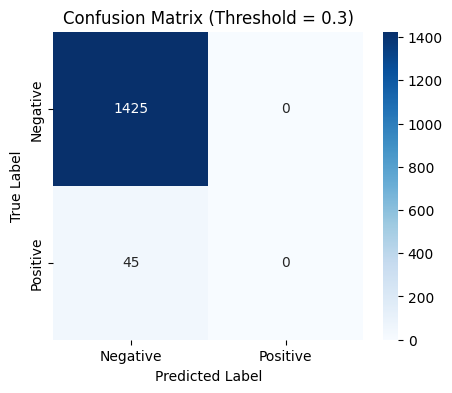

In [7]:
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()


In [8]:
best_config = analysis.best_config
best_score = analysis.best_result['recall']
best_accuracy = analysis.best_result['accuracy']
best_f1 = analysis.best_result['f1']
best_result = analysis.best_result

In [9]:
# เทรนโมเดลที่ดีที่สุดและบันทึกค่าการคาดการณ์ลง CSV
best_model = xgb.XGBClassifier(**best_config)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [11]:
# บันทึกผลลัพธ์ลง CSV
best_params_df = pd.DataFrame([{**best_config, **best_result, 'trial': trial}])
best_params_df.to_csv('./model2/best_xgb_params2.csv', mode='a', header=not pd.io.common.file_exists('./model2/best_xgb_params2.csv'), index=False)

# บันทึกค่าทั้งหมดของแต่ละ K-Fold ลง CSV
results_df = pd.DataFrame(results_list, columns=['Trial', 'Fold', 'Recall', 'Accuracy', 'Precision', 'F1', 'F1_macro', 'Best_n_estimators', 'KF_Time'])
results_df.to_csv('./model2/kf_results2.csv', mode='a', header=not pd.io.common.file_exists('./model2/kf_results2.csv'), index=False)

time_taken = time.time() - start_time
results = pd.DataFrame([[str(best_config), best_score, best_accuracy, best_f1, time_taken, trial]], columns=['best_params', 'best_score', 'best_accuracy', 'best_f1', 'time_taken', 'trial'])
results.to_csv('./time/xgb_best_params2.csv', mode='a', header=not pd.io.common.file_exists('./time/xgb_best_params2.csv'), index=False)


